In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from scipy import stats
from scipy.stats import zscore
import xgboost as xgb
import lightgbm as lgb

df = pd.read_csv("C:/Users/megde/OneDrive/Bureau/Projet machine learning (Cyber)/Global_Cybersecurity_Threats_2015-2024.csv")

# Clean column names
df.columns = df.columns.str.strip()
df.rename(columns={'Financial Loss (in Million $)': 'Financial_Loss', 
                   'Incident Resolution Time (in Hours)': 'Resolution_Time'}, inplace=True)

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())


Dataset Shape: (3000, 10)
Columns: ['Country', 'Year', 'Attack Type', 'Target Industry', 'Financial_Loss', 'Number of Affected Users', 'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used', 'Resolution_Time']

First 5 rows:
   Country  Year        Attack Type     Target Industry  Financial_Loss  \
0    China  2019           Phishing           Education           80.53   
1    China  2019         Ransomware              Retail           62.19   
2    India  2017  Man-in-the-Middle                  IT           38.65   
3       UK  2024         Ransomware  Telecommunications           41.44   
4  Germany  2018  Man-in-the-Middle                  IT           74.41   

   Number of Affected Users Attack Source Security Vulnerability Type  \
0                    773169  Hacker Group          Unpatched Software   
1                    295961  Hacker Group          Unpatched Software   
2                    605895  Hacker Group              Weak Passwords   
3             


📈 2. EXPLORATORY DATA ANALYSIS
----------------------------------------
Missing Values:
No missing values found!


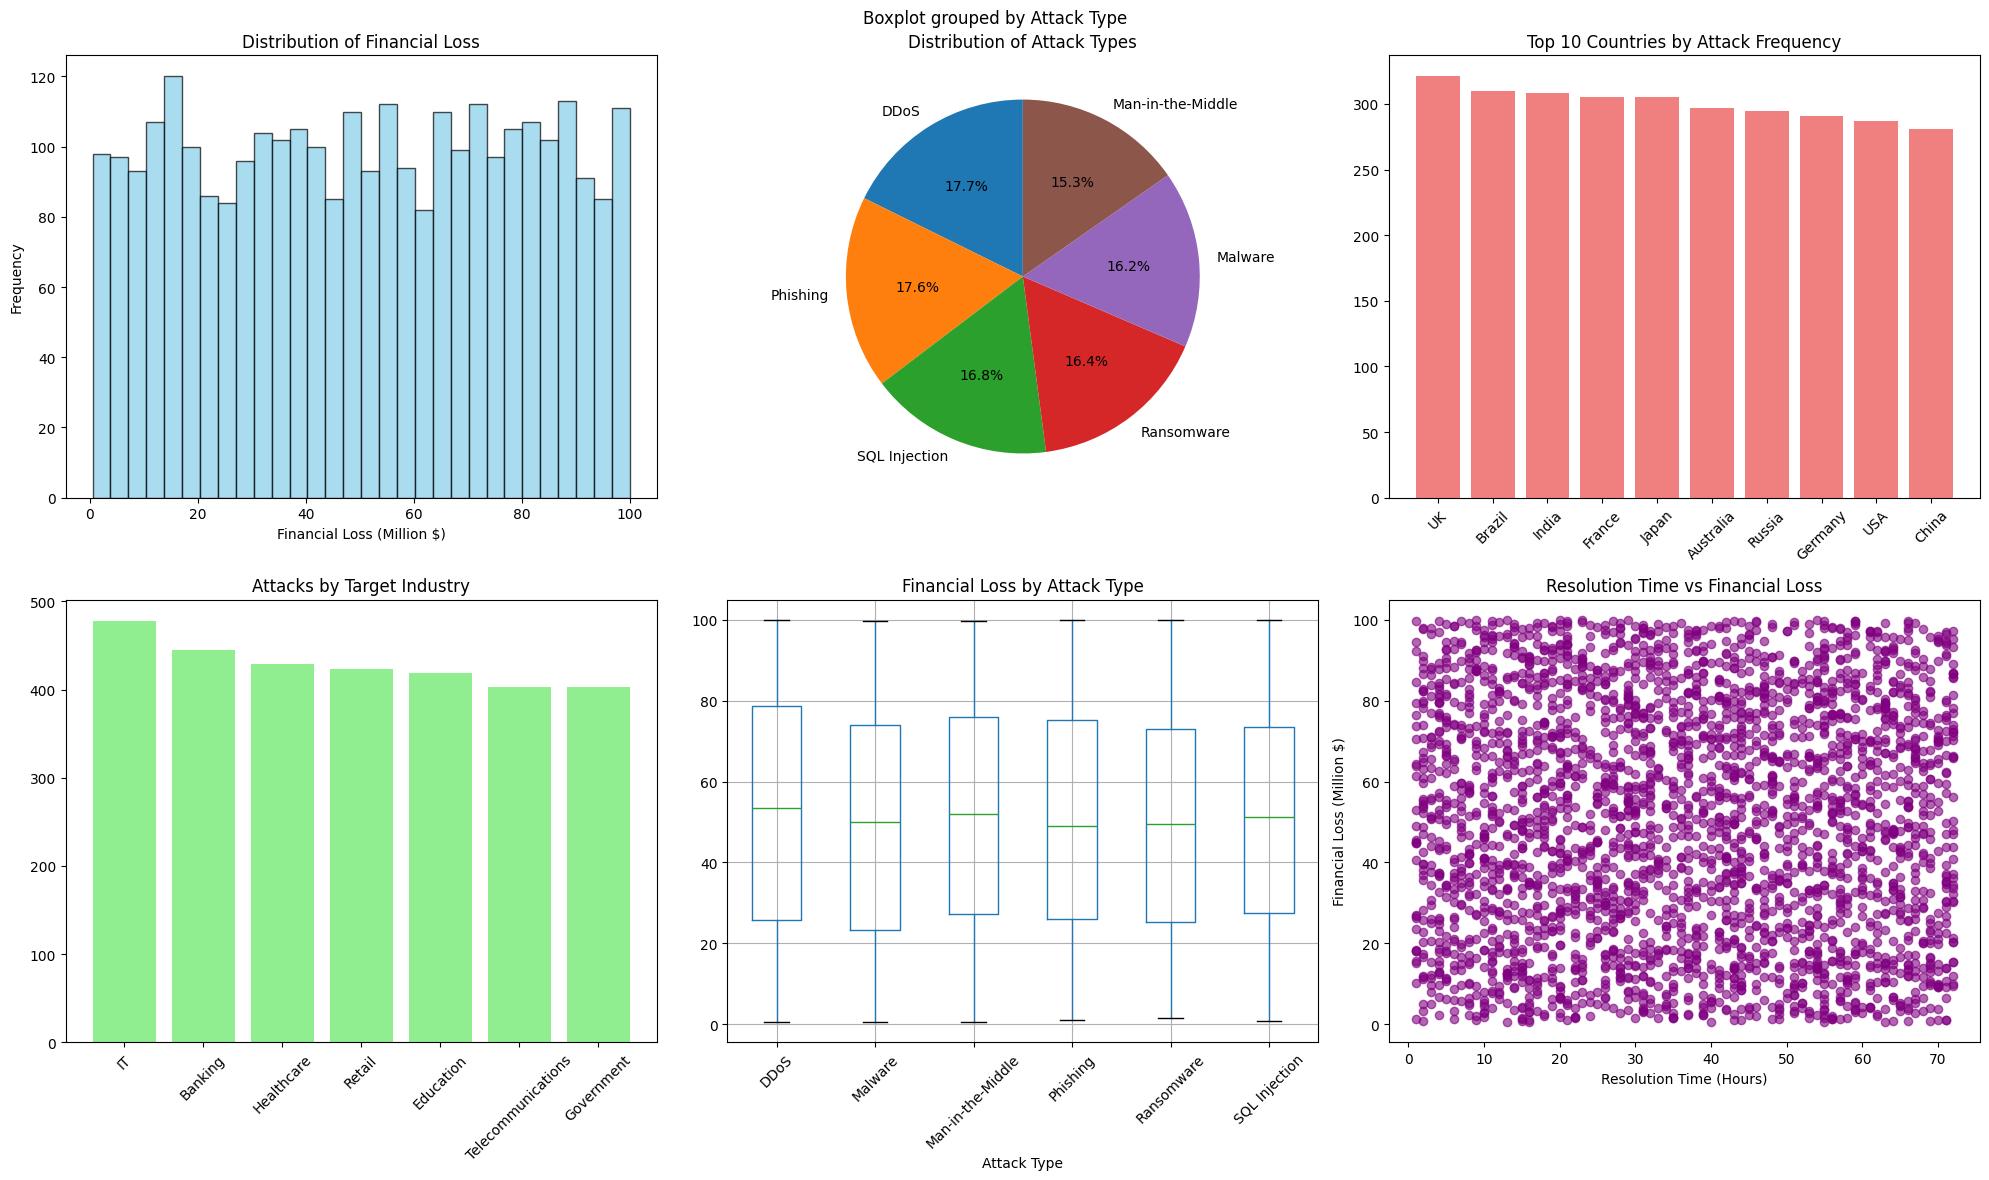


Correlation Analysis:


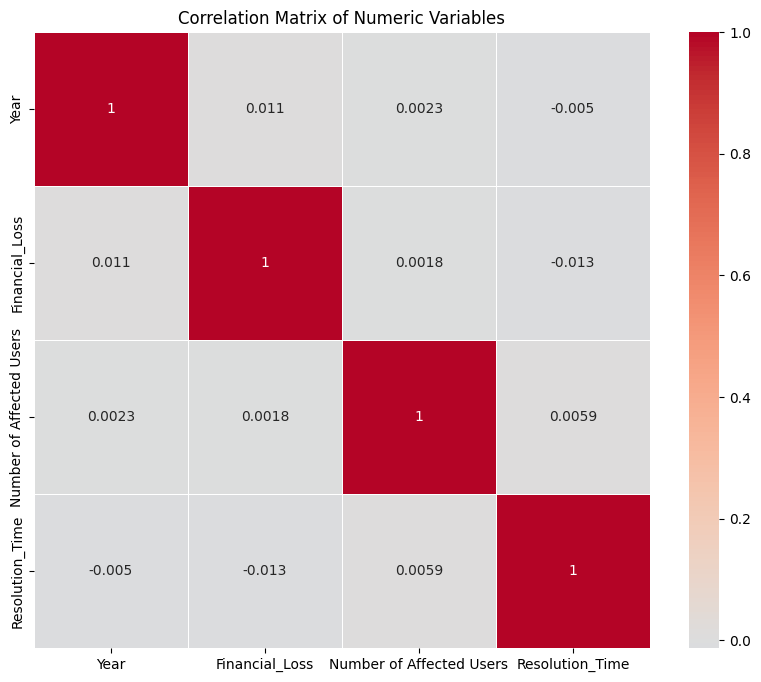

In [3]:
# 2. EXPLORATORY DATA ANALYSIS (EDA)
print("\n📈 2. EXPLORATORY DATA ANALYSIS")
print("-" * 40)

# Check for missing values
print("Missing Values:")
missing_vals = df.isnull().sum()
print(missing_vals[missing_vals > 0] if missing_vals.sum() > 0 else "No missing values found!")

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Cybersecurity Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Financial Loss Distribution
axes[0,0].hist(df['Financial_Loss'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Financial Loss')
axes[0,0].set_xlabel('Financial Loss (Million $)')
axes[0,0].set_ylabel('Frequency')

# 2. Attack Types
attack_counts = df['Attack Type'].value_counts()
axes[0,1].pie(attack_counts.values, labels=attack_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Distribution of Attack Types')

# 3. Countries with most attacks
country_counts = df['Country'].value_counts().head(10)
axes[0,2].bar(country_counts.index, country_counts.values, color='lightcoral')
axes[0,2].set_title('Top 10 Countries by Attack Frequency')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Target Industries
industry_counts = df['Target Industry'].value_counts()
axes[1,0].bar(industry_counts.index, industry_counts.values, color='lightgreen')
axes[1,0].set_title('Attacks by Target Industry')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Financial Loss by Attack Type
df.boxplot(column='Financial_Loss', by='Attack Type', ax=axes[1,1])
axes[1,1].set_title('Financial Loss by Attack Type')
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Resolution Time vs Financial Loss
axes[1,2].scatter(df['Resolution_Time'], df['Financial_Loss'], alpha=0.6, color='purple')
axes[1,2].set_title('Resolution Time vs Financial Loss')
axes[1,2].set_xlabel('Resolution Time (Hours)')
axes[1,2].set_ylabel('Financial Loss (Million $)')

plt.tight_layout()
plt.show()

# Correlation Analysis
print("\nCorrelation Analysis:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Variables')
plt.show()



🔍 3. ANOMALY DETECTION & HANDLING
----------------------------------------

Financial_Loss:
  IQR Method: 0 outliers
  Z-Score Method: 0 outliers
  IQR Bounds: [-49.05, 150.44]

Number of Affected Users:
  IQR Method: 0 outliers
  Z-Score Method: 0 outliers
  IQR Bounds: [-497619.62, 1511513.38]

Resolution_Time:
  IQR Method: 0 outliers
  Z-Score Method: 0 outliers
  IQR Bounds: [-35.00, 109.00]

Year:
  IQR Method: 0 outliers
  Z-Score Method: 0 outliers
  IQR Bounds: [2009.50, 2029.50]


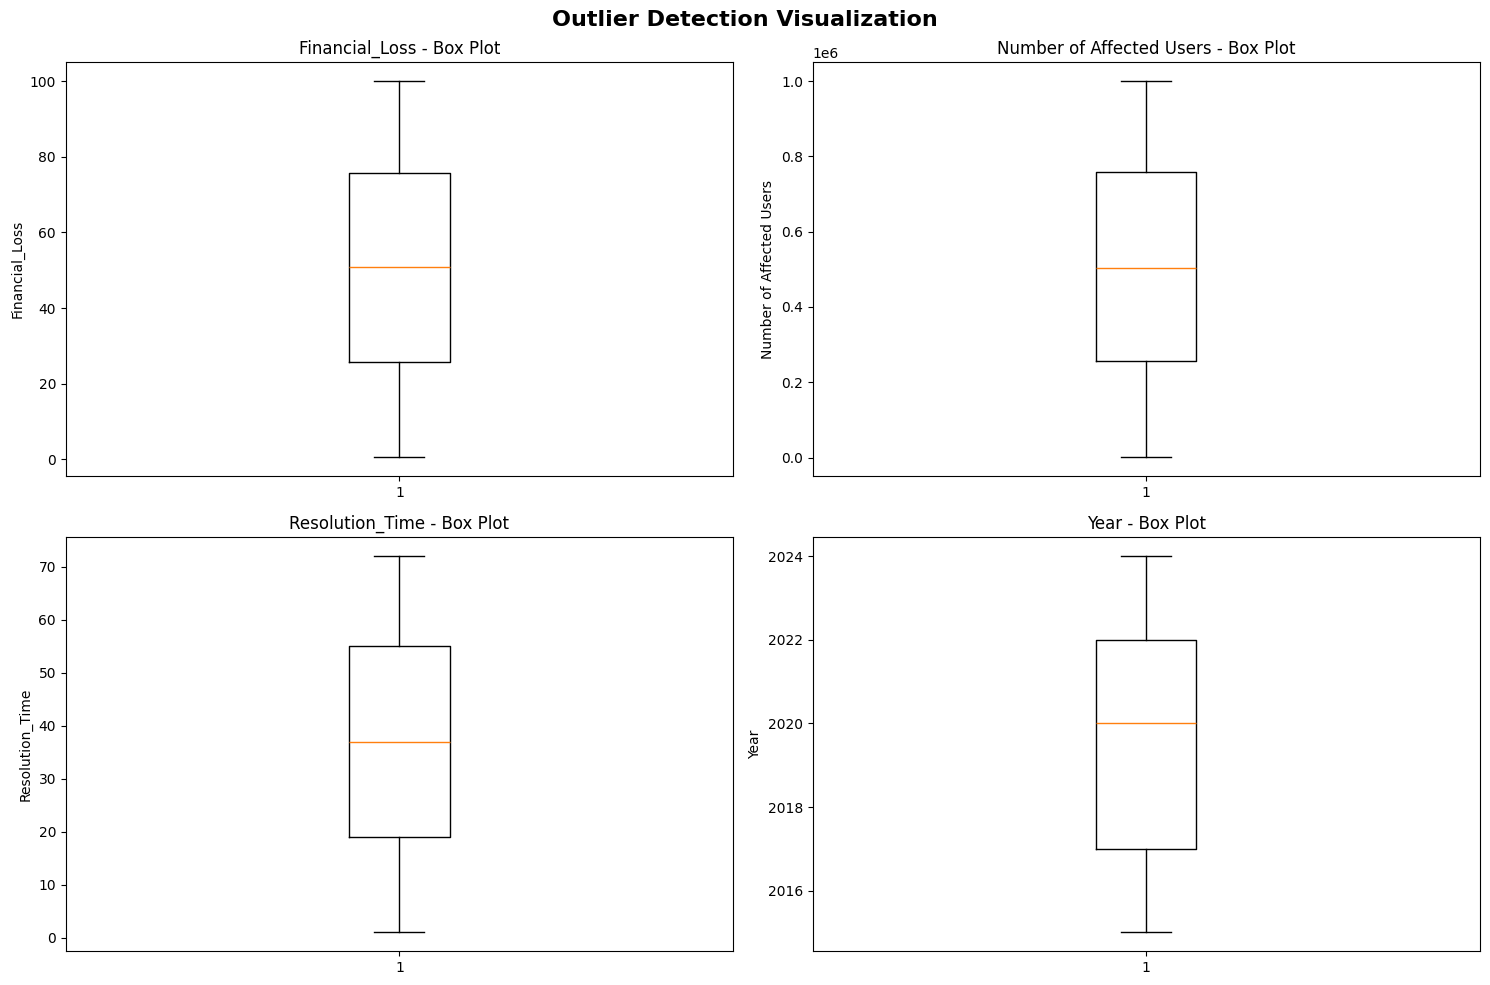


Financial_Loss: Capped 0 outliers

Number of Affected Users: Capped 0 outliers

Resolution_Time: Capped 0 outliers

Dataset shape after outlier handling: (3000, 10)


In [4]:
# 3. ANOMALY DETECTION & HANDLING
print("\n🔍 3. ANOMALY DETECTION & HANDLING")
print("-" * 40)

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

def detect_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs(zscore(df[column]))
    outliers = df[z_scores > threshold]
    return outliers

# Detect outliers in key numeric columns
numeric_columns = ['Financial_Loss', 'Number of Affected Users', 'Resolution_Time', 'Year']

outlier_summary = {}
for col in numeric_columns:
    if col in df.columns:
        # IQR Method
        outliers_iqr, lower, upper = detect_outliers_iqr(df, col)
        
        # Z-Score Method
        outliers_zscore = detect_outliers_zscore(df, col)
        
        outlier_summary[col] = {
            'IQR_outliers': len(outliers_iqr),
            'IQR_bounds': (lower, upper),
            'ZScore_outliers': len(outliers_zscore)
        }
        
        print(f"\n{col}:")
        print(f"  IQR Method: {len(outliers_iqr)} outliers")
        print(f"  Z-Score Method: {len(outliers_zscore)} outliers")
        print(f"  IQR Bounds: [{lower:.2f}, {upper:.2f}]")

# Visualize outliers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Outlier Detection Visualization', fontsize=16, fontweight='bold')

for i, col in enumerate(['Financial_Loss', 'Number of Affected Users', 'Resolution_Time', 'Year']):
    if col in df.columns:
        row, col_idx = i // 2, i % 2
        
        # Box plot
        axes[row, col_idx].boxplot(df[col])
        axes[row, col_idx].set_title(f'{col} - Box Plot')
        axes[row, col_idx].set_ylabel(col)

plt.tight_layout()
plt.show()

# Handle outliers using IQR method (capping)
df_cleaned = df.copy()

for col in ['Financial_Loss', 'Number of Affected Users', 'Resolution_Time']:
    if col in df_cleaned.columns:
        outliers, lower, upper = detect_outliers_iqr(df_cleaned, col)
        
        # Cap outliers
        df_cleaned[col] = df_cleaned[col].clip(lower=lower, upper=upper)
        
        print(f"\n{col}: Capped {len(outliers)} outliers")

print(f"\nDataset shape after outlier handling: {df_cleaned.shape}")


In [5]:
# 4. DATA PREPROCESSING
print("\n🔧 4. DATA PREPROCESSING")
print("-" * 40)

# Create a copy for preprocessing
df_processed = df_cleaned.copy()

# Encode categorical variables
label_encoders = {}
categorical_columns = ['Country', 'Attack Type', 'Target Industry', 'Attack Source', 
                      'Security Vulnerability Type', 'Defense Mechanism Used']

for col in categorical_columns:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col])
        label_encoders[col] = le
        print(f"Encoded {col}: {len(le.classes_)} unique categories")

# Create additional features
print("\nFeature Engineering:")

# 1. Attack severity based on financial loss
df_processed['Attack_Severity'] = pd.cut(df_processed['Financial_Loss'], 
                                        bins=[0, 25, 50, 75, 100], 
                                        labels=['Low', 'Medium', 'High', 'Critical'])

# 2. Time-based features
df_processed['Decade'] = (df_processed['Year'] // 10) * 10
df_processed['Years_Since_2015'] = df_processed['Year'] - 2015

# 3. Efficiency metric
df_processed['Loss_per_User'] = df_processed['Financial_Loss'] / (df_processed['Number of Affected Users'] + 1)

# 4. Resolution efficiency
df_processed['Loss_per_Hour'] = df_processed['Financial_Loss'] / (df_processed['Resolution_Time'] + 1)

print("✅ Created new features:")
print("  - Attack_Severity (categorical)")
print("  - Decade (numeric)")
print("  - Years_Since_2015 (numeric)")
print("  - Loss_per_User (numeric)")
print("  - Loss_per_Hour (numeric)")

# Select features for modeling
feature_columns = [col for col in df_processed.columns if col.endswith('_encoded')] + \
                 ['Year', 'Number of Affected Users', 'Resolution_Time', 
                  'Years_Since_2015', 'Loss_per_User', 'Loss_per_Hour']

# Remove target from features if present
feature_columns = [col for col in feature_columns if col != 'Financial_Loss']

X = df_processed[feature_columns]
y = df_processed['Financial_Loss']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features used: {feature_columns}")



🔧 4. DATA PREPROCESSING
----------------------------------------
Encoded Country: 10 unique categories
Encoded Attack Type: 6 unique categories
Encoded Target Industry: 7 unique categories
Encoded Attack Source: 4 unique categories
Encoded Security Vulnerability Type: 4 unique categories
Encoded Defense Mechanism Used: 5 unique categories

Feature Engineering:
✅ Created new features:
  - Attack_Severity (categorical)
  - Decade (numeric)
  - Years_Since_2015 (numeric)
  - Loss_per_User (numeric)
  - Loss_per_Hour (numeric)

Feature matrix shape: (3000, 12)
Target vector shape: (3000,)
Features used: ['Country_encoded', 'Attack Type_encoded', 'Target Industry_encoded', 'Attack Source_encoded', 'Security Vulnerability Type_encoded', 'Defense Mechanism Used_encoded', 'Year', 'Number of Affected Users', 'Resolution_Time', 'Years_Since_2015', 'Loss_per_User', 'Loss_per_Hour']


In [6]:
# 5. OPTIMAL TRAIN-TEST SPLIT & CROSS-VALIDATION STRATEGY
print("\n🎯 5. OPTIMAL TRAIN-TEST SPLIT & CROSS-VALIDATION")
print("-" * 40)

# Split the data with stratification based on attack severity
# First encode attack severity for stratification
severity_encoder = LabelEncoder()
severity_encoded = severity_encoder.fit_transform(df_processed['Attack_Severity'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=severity_encoded
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training set ratio: {X_train.shape[0]/len(X)*100:.1f}%")

# Scale features
scaler = RobustScaler()  # More robust to outliers than StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Applied RobustScaler for feature scaling")

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("✅ Using 5-fold Stratified Cross-Validation")



🎯 5. OPTIMAL TRAIN-TEST SPLIT & CROSS-VALIDATION
----------------------------------------
Training set size: 2400 samples
Test set size: 600 samples
Training set ratio: 80.0%
✅ Applied RobustScaler for feature scaling
✅ Using 5-fold Stratified Cross-Validation


In [7]:
# 6. MACHINE LEARNING MODELS
print("\n🤖 6. MACHINE LEARNING MODELS")
print("-" * 40)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'SVR': SVR(kernel='rbf'),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

# Store results
results = {}
cv_results = {}

print("Training and evaluating models...")
print("=" * 50)

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Cross-validation scores
    try:
        # Use scaled data for models that benefit from scaling
        if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 
                   'ElasticNet', 'SVR', 'KNN']:
            cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                                      cv=5, scoring='r2', n_jobs=-1)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            cv_scores = cross_val_score(model, X_train, y_train, 
                                      cv=5, scoring='r2', n_jobs=-1)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'CV_Mean': cv_scores.mean(),
            'CV_Std': cv_scores.std()
        }
        
        cv_results[name] = cv_scores
        
        print(f"  ✅ R² Score: {r2:.4f}")
        print(f"  📊 CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        print(f"  📉 RMSE: {rmse:.4f}")
        
    except Exception as e:
        print(f"  ❌ Error training {name}: {str(e)}")
        continue

print("\n" + "="*50)
print("🏆 MODEL COMPARISON RESULTS")
print("="*50)



🤖 6. MACHINE LEARNING MODELS
----------------------------------------
Training and evaluating models...

🔄 Training Linear Regression...
  ✅ R² Score: 0.1521
  📊 CV Score: 0.1499 (±0.0285)
  📉 RMSE: 26.2203

🔄 Training Ridge Regression...
  ✅ R² Score: 0.1521
  📊 CV Score: 0.1499 (±0.0285)
  📉 RMSE: 26.2199

🔄 Training Lasso Regression...
  ✅ R² Score: 0.1510
  📊 CV Score: 0.1529 (±0.0229)
  📉 RMSE: 26.2369

🔄 Training ElasticNet...
  ✅ R² Score: 0.1336
  📊 CV Score: 0.1326 (±0.0233)
  📉 RMSE: 26.5048

🔄 Training Decision Tree...
  ✅ R² Score: 0.9722
  📊 CV Score: 0.9601 (±0.0086)
  📉 RMSE: 4.7457

🔄 Training Random Forest...
  ✅ R² Score: 0.9898
  📊 CV Score: 0.9865 (±0.0031)
  📉 RMSE: 2.8737

🔄 Training Extra Trees...
  ✅ R² Score: 0.9980
  📊 CV Score: 0.9964 (±0.0011)
  📉 RMSE: 1.2589

🔄 Training Gradient Boosting...
  ✅ R² Score: 0.9724
  📊 CV Score: 0.9695 (±0.0027)
  📉 RMSE: 4.7269

🔄 Training XGBoost...
  ❌ Error training XGBoost: 'super' object has no attribute '__sklearn_tags


📊 7. MODEL EVALUATION & COMPARISON
----------------------------------------
Model Performance Summary:
                        MSE     RMSE      MAE      R2  CV_Mean  CV_Std
Extra Trees          1.5847   1.2589   0.7156  0.9980   0.9964  0.0011
LightGBM             6.6140   2.5718   1.7841  0.9918   0.9885  0.0027
Random Forest        8.2580   2.8737   1.5417  0.9898   0.9865  0.0031
Gradient Boosting   22.3432   4.7269   3.4927  0.9724   0.9695  0.0027
Decision Tree       22.5213   4.7457   2.9563  0.9722   0.9601  0.0086
KNN                286.4659  16.9253  13.3723  0.6467   0.6279  0.0127
Ridge Regression   687.4807  26.2199  22.4826  0.1521   0.1499  0.0285
Linear Regression  687.5015  26.2203  22.4816  0.1521   0.1499  0.0285
Lasso Regression   688.3761  26.2369  22.7280  0.1510   0.1529  0.0229
SVR                694.9752  26.3624  22.8207  0.1429   0.1265  0.0228
ElasticNet         702.5024  26.5048  23.0480  0.1336   0.1326  0.0233


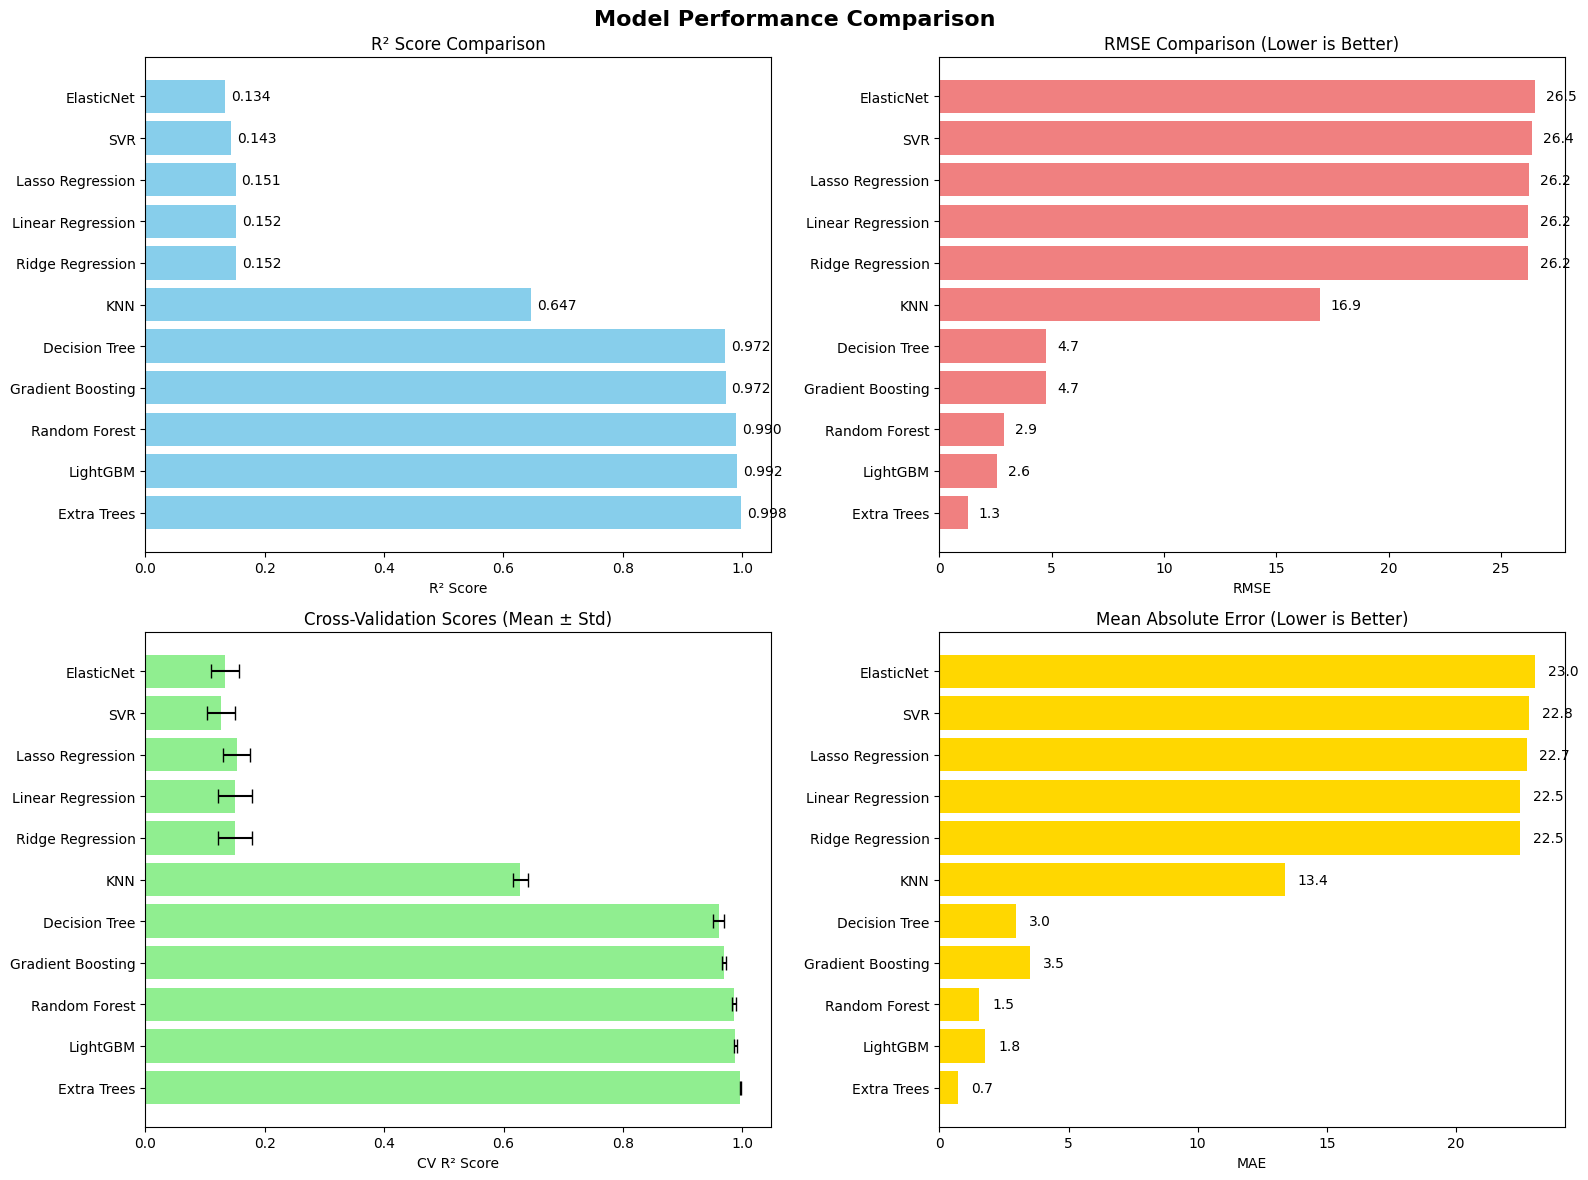

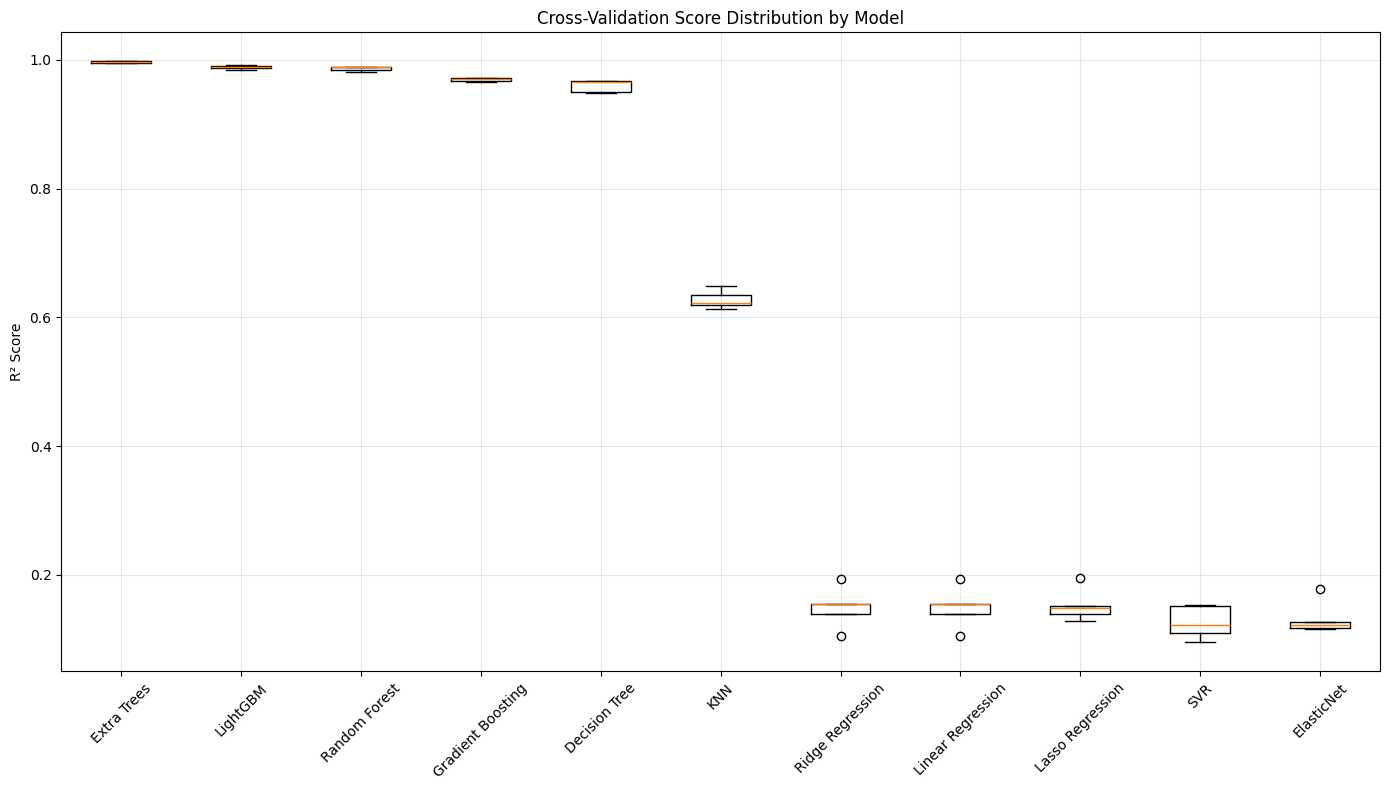

In [8]:
# 7. MODEL EVALUATION & COMPARISON (continued)
print("\n📊 7. MODEL EVALUATION & COMPARISON")
print("-" * 40)

# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R2', ascending=False)

print("Model Performance Summary:")
print(results_df.round(4))

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. R² Score comparison
axes[0,0].barh(results_df.index, results_df['R2'], color='skyblue')
axes[0,0].set_title('R² Score Comparison')
axes[0,0].set_xlabel('R² Score')
for i, v in enumerate(results_df['R2']):
    axes[0,0].text(v + 0.01, i, f'{v:.3f}', va='center')

# 2. RMSE comparison
axes[0,1].barh(results_df.index, results_df['RMSE'], color='lightcoral')
axes[0,1].set_title('RMSE Comparison (Lower is Better)')
axes[0,1].set_xlabel('RMSE')
for i, v in enumerate(results_df['RMSE']):
    axes[0,1].text(v + 0.5, i, f'{v:.1f}', va='center')

# 3. Cross-validation scores
cv_means = [results_df.loc[model, 'CV_Mean'] for model in results_df.index]
cv_stds = [results_df.loc[model, 'CV_Std'] for model in results_df.index]

axes[1,0].barh(results_df.index, cv_means, xerr=cv_stds, color='lightgreen', capsize=5)
axes[1,0].set_title('Cross-Validation Scores (Mean ± Std)')
axes[1,0].set_xlabel('CV R² Score')

# 4. MAE comparison
axes[1,1].barh(results_df.index, results_df['MAE'], color='gold')
axes[1,1].set_title('Mean Absolute Error (Lower is Better)')
axes[1,1].set_xlabel('MAE')
for i, v in enumerate(results_df['MAE']):
    axes[1,1].text(v + 0.5, i, f'{v:.1f}', va='center')

plt.tight_layout()
plt.show()

# Box plot of cross-validation scores
plt.figure(figsize=(14, 8))
cv_data = [cv_results[model] for model in results_df.index if model in cv_results]
plt.boxplot(cv_data, labels=results_df.index)
plt.title('Cross-Validation Score Distribution by Model')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
# 8. HYPERPARAMETER TUNING FOR BEST MODELS
print("\n⚙️ 8. HYPERPARAMETER TUNING")
print("-" * 40)

# Select top 3 models for hyperparameter tuning
top_models = results_df.head(3).index.tolist()
print(f"Tuning hyperparameters for top 3 models: {top_models}")

tuned_results = {}

# Define parameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100]
    },
    'Extra Trees': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

for model_name in top_models:
    if model_name in param_grids:
        print(f"\n🔧 Tuning {model_name}...")
        
        # Get the base model
        base_model = models[model_name]
        
        # Grid search
        grid_search = GridSearchCV(
            base_model, 
            param_grids[model_name],
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=0
        )
        
        # Fit grid search
        if model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 
                         'ElasticNet', 'SVR', 'KNN']:
            grid_search.fit(X_train_scaled, y_train)
            y_pred_tuned = grid_search.predict(X_test_scaled)
        else:
            grid_search.fit(X_train, y_train)
            y_pred_tuned = grid_search.predict(X_test)
        
        # Calculate metrics for tuned model
        mse_tuned = mean_squared_error(y_test, y_pred_tuned)
        rmse_tuned = np.sqrt(mse_tuned)
        mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
        r2_tuned = r2_score(y_test, y_pred_tuned)
        
        tuned_results[model_name] = {
            'Best_Params': grid_search.best_params_,
            'Best_CV_Score': grid_search.best_score_,
            'Test_R2': r2_tuned,
            'Test_RMSE': rmse_tuned,
            'Test_MAE': mae_tuned,
            'Improvement': r2_tuned - results[model_name]['R2']
        }
        
        print(f"  ✅ Best CV Score: {grid_search.best_score_:.4f}")
        print(f"  📊 Test R² Score: {r2_tuned:.4f}")
        print(f"  📈 Improvement: {r2_tuned - results[model_name]['R2']:+.4f}")
        print(f"  ⚙️ Best Parameters: {grid_search.best_params_}")

print("\n" + "="*60)
print("🏆 HYPERPARAMETER TUNING RESULTS")
print("="*60)

for model_name, result in tuned_results.items():
    print(f"\n{model_name}:")
    print(f"  Original R²: {results[model_name]['R2']:.4f}")
    print(f"  Tuned R²: {result['Test_R2']:.4f}")
    print(f"  Improvement: {result['Improvement']:+.4f}")
    print(f"  Best Parameters: {result['Best_Params']}")



⚙️ 8. HYPERPARAMETER TUNING
----------------------------------------
Tuning hyperparameters for top 3 models: ['Extra Trees', 'LightGBM', 'Random Forest']

🔧 Tuning Extra Trees...
  ✅ Best CV Score: 0.9965
  📊 Test R² Score: 0.9982
  📈 Improvement: +0.0002
  ⚙️ Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

🔧 Tuning LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 12
[LightGBM] [Info] Start training from score 50.493692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 


🎯 9. FEATURE IMPORTANCE ANALYSIS
----------------------------------------
Analyzing feature importance for: Extra Trees

Top 10 Most Important Features:
                                feature  importance
11                        Loss_per_Hour    0.671750
8                       Resolution_Time    0.265768
10                        Loss_per_User    0.039145
7              Number of Affected Users    0.016030
2               Target Industry_encoded    0.001086
3                 Attack Source_encoded    0.000969
0                       Country_encoded    0.000943
1                   Attack Type_encoded    0.000933
4   Security Vulnerability Type_encoded    0.000900
9                      Years_Since_2015    0.000832


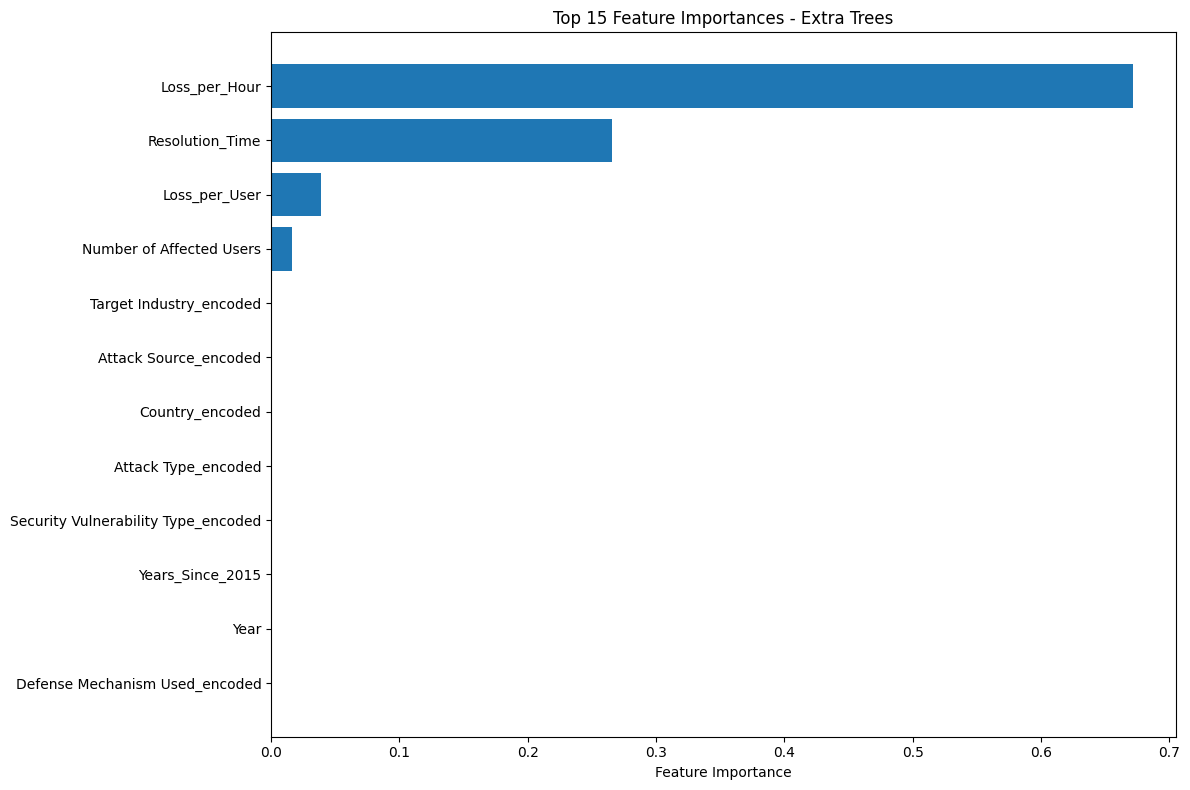

In [10]:
# 9. FEATURE IMPORTANCE ANALYSIS
print("\n🎯 9. FEATURE IMPORTANCE ANALYSIS")
print("-" * 40)

# Get the best model (highest R² score after tuning)
best_model_name = max(tuned_results.keys(), key=lambda x: tuned_results[x]['Test_R2']) if tuned_results else results_df.index[0]
print(f"Analyzing feature importance for: {best_model_name}")

# Train the best model with best parameters if available
if best_model_name in tuned_results:
    best_model = models[best_model_name].set_params(**tuned_results[best_model_name]['Best_Params'])
else:
    best_model = models[best_model_name]

# Fit the model
if best_model_name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 
                      'ElasticNet', 'SVR', 'KNN']:
    best_model.fit(X_train_scaled, y_train)
    final_predictions = best_model.predict(X_test_scaled)
else:
    best_model.fit(X_train, y_train)
    final_predictions = best_model.predict(X_test)

# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# For linear models, show coefficients
elif hasattr(best_model, 'coef_'):
    feature_coef = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': best_model.coef_
    })
    feature_coef['abs_coefficient'] = abs(feature_coef['coefficient'])
    feature_coef = feature_coef.sort_values('abs_coefficient', ascending=False)
    
    print("\nTop 10 Most Important Features (by coefficient magnitude):")
    print(feature_coef.head(10))
    
    # Plot coefficients
    plt.figure(figsize=(12, 8))
    top_features = feature_coef.head(15)
    colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
    plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 15 Feature Coefficients - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



🎯 10. FINAL MODEL EVALUATION
----------------------------------------
🏆 FINAL MODEL: Extra Trees
📊 R² Score: 0.9982
📉 RMSE: 1.2051
📉 MAE: 0.6667
📉 MSE: 1.4522


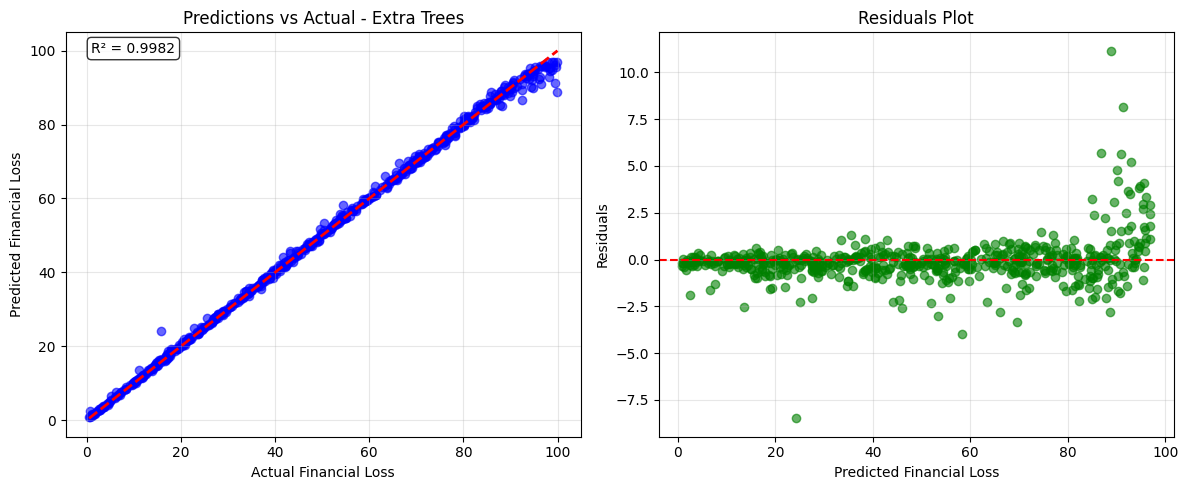

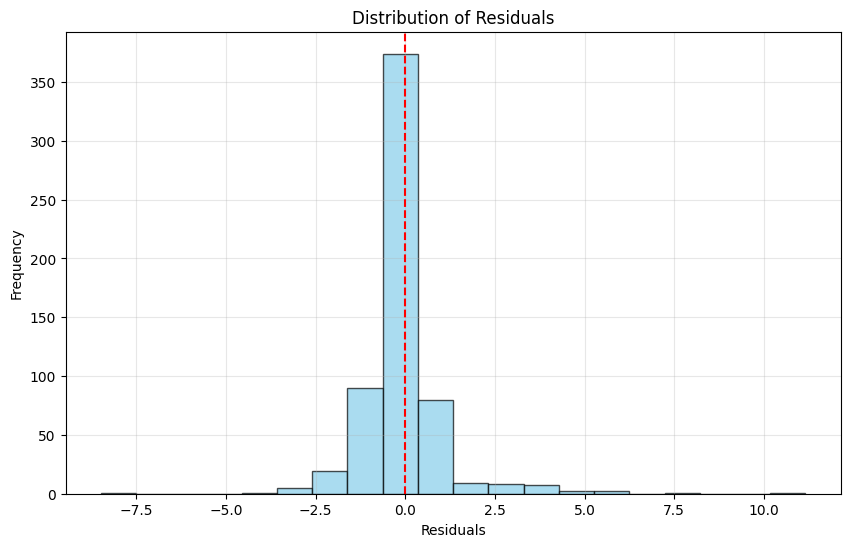

In [11]:
# 10. FINAL MODEL EVALUATION & PREDICTIONS
print("\n🎯 10. FINAL MODEL EVALUATION")
print("-" * 40)

# Final metrics
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, final_predictions)
final_r2 = r2_score(y_test, final_predictions)

print(f"🏆 FINAL MODEL: {best_model_name}")
print(f"📊 R² Score: {final_r2:.4f}")
print(f"📉 RMSE: {final_rmse:.4f}")
print(f"📉 MAE: {final_mae:.4f}")
print(f"📉 MSE: {final_mse:.4f}")

# Prediction vs Actual plot
plt.figure(figsize=(12, 5))

# Subplot 1: Predictions vs Actual
plt.subplot(1, 2, 1)
plt.scatter(y_test, final_predictions, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Financial Loss')
plt.ylabel('Predicted Financial Loss')
plt.title(f'Predictions vs Actual - {best_model_name}')
plt.grid(True, alpha=0.3)

# Add R² score to plot
plt.text(0.05, 0.95, f'R² = {final_r2:.4f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Subplot 2: Residuals plot
plt.subplot(1, 2, 2)
residuals = y_test - final_predictions
plt.scatter(final_predictions, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Financial Loss')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residuals distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)
plt.show()



💼 11. BUSINESS INSIGHTS & RECOMMENDATIONS
----------------------------------------
🔍 KEY INSIGHTS FROM THE DATA:

1. MOST COSTLY ATTACK TYPES (by average loss):
                    mean       sum  count
Attack Type                              
DDoS               52.04  27630.92    531
Man-in-the-Middle  51.31  23550.87    459
Phishing           50.46  26693.29    529
SQL Injection      50.01  25156.56    503
Ransomware         49.65  24479.32    493
Malware            49.42  23967.95    485

2. INDUSTRY ANALYSIS:
                   Financial_Loss                 Number of Affected Users  \
                             mean       sum count                     mean   
Target Industry                                                              
Banking                     51.17  22772.39   445                505839.11   
Education                   47.90  20071.43   419                513137.79   
Government                  52.62  21205.33   403                499352.43   
Healthcare 

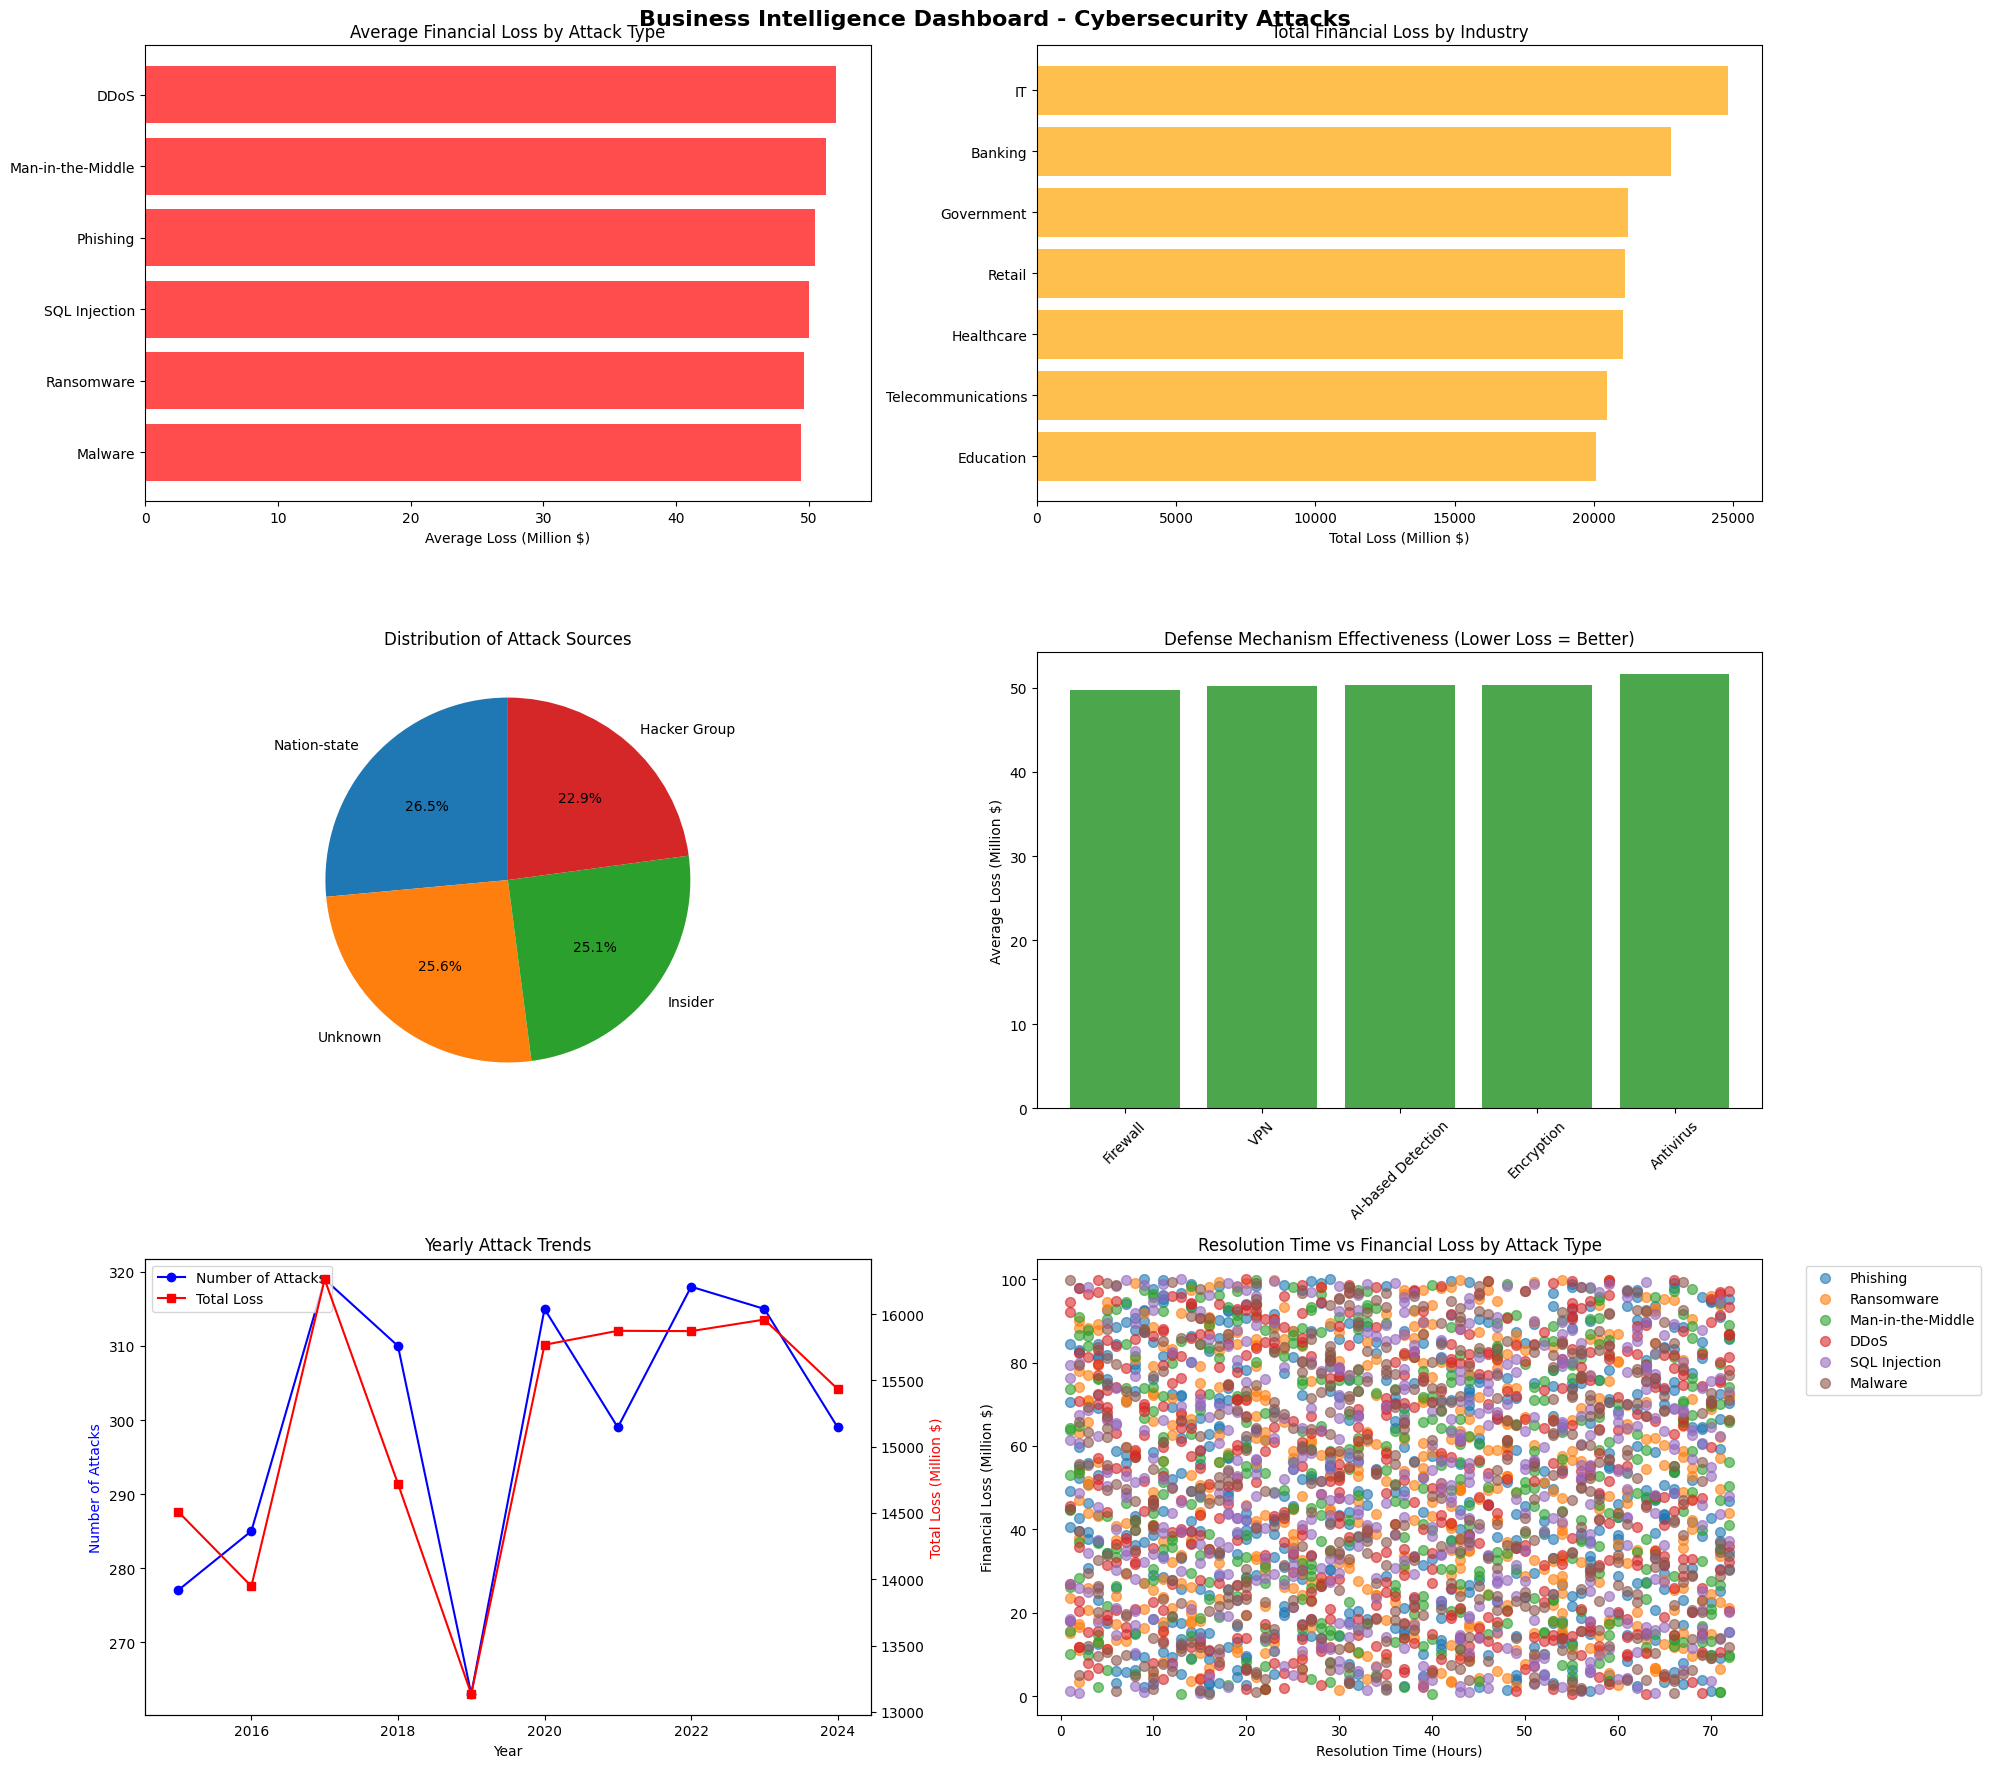


🎯 ACTIONABLE BUSINESS RECOMMENDATIONS:

1. 🛡️ DEFENSE STRATEGY RECOMMENDATIONS:
   ✅ MOST EFFECTIVE defenses (lowest avg loss):
      • Firewall: $49.7M avg loss, 35.7h avg resolution
      • VPN: $50.2M avg loss, 36.9h avg resolution
      • AI-based Detection: $50.4M avg loss, 36.6h avg resolution

   ❌ LEAST EFFECTIVE defenses (highest avg loss):
      • AI-based Detection: $50.4M avg loss, 36.6h avg resolution
      • Encryption: $50.4M avg loss, 36.6h avg resolution
      • Antivirus: $51.7M avg loss, 36.6h avg resolution

2. 🏭 HIGH-RISK INDUSTRIES:
   • Government: $52.6M avg loss, 403 attacks
   • IT: $51.9M avg loss, 478 attacks
   • Banking: $51.2M avg loss, 445 attacks

3. ⚠️ PRIORITY ATTACK TYPES TO DEFEND AGAINST:
   • DDoS: $52.0M avg loss, 531 incidents
   • Man-in-the-Middle: $51.3M avg loss, 459 incidents
   • Phishing: $50.5M avg loss, 529 incidents

4. 🔓 CRITICAL VULNERABILITIES TO ADDRESS:
   • Social Engineering: $50.9M avg loss, 747 incidents
   • Weak Passwords: 

In [12]:
# 11. BUSINESS INSIGHTS & RECOMMENDATIONS
print("\n💼 11. BUSINESS INSIGHTS & RECOMMENDATIONS")
print("-" * 40)

# Analyze patterns in the data
print("🔍 KEY INSIGHTS FROM THE DATA:")
print("="*50)

# 1. Most costly attack types
attack_loss = df.groupby('Attack Type')['Financial_Loss'].agg(['mean', 'sum', 'count']).round(2)
attack_loss = attack_loss.sort_values('mean', ascending=False)
print("\n1. MOST COSTLY ATTACK TYPES (by average loss):")
print(attack_loss)

# 2. Most targeted industries
industry_analysis = df.groupby('Target Industry').agg({
    'Financial_Loss': ['mean', 'sum', 'count'],
    'Number of Affected Users': 'mean',
    'Resolution_Time': 'mean'
}).round(2)
print("\n2. INDUSTRY ANALYSIS:")
print(industry_analysis)

# 3. Attack source analysis (FIXED)
source_analysis = df.groupby('Attack Source').agg({
    'Financial_Loss': ['mean', 'sum', 'count'],
    'Resolution_Time': 'mean'
}).round(2)
source_analysis = source_analysis.sort_values(('Financial_Loss', 'mean'), ascending=False)
print("\n3. ATTACK SOURCE ANALYSIS:")
print(source_analysis)

# 4. Vulnerability type analysis
vuln_analysis = df.groupby('Security Vulnerability Type').agg({
    'Financial_Loss': ['mean', 'count'],
    'Resolution_Time': 'mean'
}).round(2)
vuln_analysis = vuln_analysis.sort_values(('Financial_Loss', 'mean'), ascending=False)
print("\n4. SECURITY VULNERABILITY ANALYSIS:")
print(vuln_analysis)

# 5. Defense mechanism effectiveness
defense_analysis = df.groupby('Defense Mechanism Used').agg({
    'Financial_Loss': 'mean',
    'Resolution_Time': 'mean',
    'Number of Affected Users': 'mean'
}).round(2)
defense_analysis = defense_analysis.sort_values('Financial_Loss', ascending=True)  # Lower is better
print("\n5. DEFENSE MECHANISM EFFECTIVENESS:")
print(defense_analysis)

# 6. Country-wise analysis
country_analysis = df.groupby('Country').agg({
    'Financial_Loss': ['mean', 'sum', 'count'],
    'Resolution_Time': 'mean'
}).round(2)
country_analysis = country_analysis.sort_values(('Financial_Loss', 'sum'), ascending=False)
print("\n6. COUNTRY-WISE ANALYSIS:")
print(country_analysis.head(10))

# 7. Yearly trends
yearly_trends = df.groupby('Year').agg({
    'Financial_Loss': ['mean', 'sum', 'count'],
    'Number of Affected Users': 'mean',
    'Resolution_Time': 'mean'
}).round(2)
print("\n7. YEARLY TRENDS:")
print(yearly_trends)

# Create comprehensive visualizations for business insights
fig, axes = plt.subplots(3, 2, figsize=(20, 18))
fig.suptitle('Business Intelligence Dashboard - Cybersecurity Attacks', fontsize=16, fontweight='bold')

# 1. Average Financial Loss by Attack Type
attack_avg = df.groupby('Attack Type')['Financial_Loss'].mean().sort_values(ascending=True)
axes[0,0].barh(attack_avg.index, attack_avg.values, color='red', alpha=0.7)
axes[0,0].set_title('Average Financial Loss by Attack Type')
axes[0,0].set_xlabel('Average Loss (Million $)')

# 2. Total Financial Loss by Industry
industry_total = df.groupby('Target Industry')['Financial_Loss'].sum().sort_values(ascending=True)
axes[0,1].barh(industry_total.index, industry_total.values, color='orange', alpha=0.7)
axes[0,1].set_title('Total Financial Loss by Industry')
axes[0,1].set_xlabel('Total Loss (Million $)')

# 3. Attack Source Distribution
source_counts = df['Attack Source'].value_counts()
axes[1,0].pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Distribution of Attack Sources')

# 4. Defense Mechanism Effectiveness
defense_eff = df.groupby('Defense Mechanism Used')['Financial_Loss'].mean().sort_values(ascending=True)
axes[1,1].bar(defense_eff.index, defense_eff.values, color='green', alpha=0.7)
axes[1,1].set_title('Defense Mechanism Effectiveness (Lower Loss = Better)')
axes[1,1].set_ylabel('Average Loss (Million $)')
axes[1,1].tick_params(axis='x', rotation=45)

# 5. Yearly Attack Trends
yearly_counts = df.groupby('Year').size()
yearly_loss = df.groupby('Year')['Financial_Loss'].sum()

ax5 = axes[2,0]
ax5_twin = ax5.twinx()

line1 = ax5.plot(yearly_counts.index, yearly_counts.values, 'b-o', label='Number of Attacks')
line2 = ax5_twin.plot(yearly_loss.index, yearly_loss.values, 'r-s', label='Total Loss')

ax5.set_xlabel('Year')
ax5.set_ylabel('Number of Attacks', color='b')
ax5_twin.set_ylabel('Total Loss (Million $)', color='r')
ax5.set_title('Yearly Attack Trends')

# Combine legends
lines1, labels1 = ax5.get_legend_handles_labels()
lines2, labels2 = ax5_twin.get_legend_handles_labels()
ax5.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 6. Resolution Time vs Financial Loss by Attack Type
for i, attack_type in enumerate(df['Attack Type'].unique()):
    subset = df[df['Attack Type'] == attack_type]
    axes[2,1].scatter(subset['Resolution_Time'], subset['Financial_Loss'], 
                     label=attack_type, alpha=0.6, s=50)

axes[2,1].set_xlabel('Resolution Time (Hours)')
axes[2,1].set_ylabel('Financial Loss (Million $)')
axes[2,1].set_title('Resolution Time vs Financial Loss by Attack Type')
axes[2,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Generate actionable business recommendations
print("\n🎯 ACTIONABLE BUSINESS RECOMMENDATIONS:")
print("="*60)

# Find the most effective defense mechanisms
best_defenses = defense_analysis.sort_values('Financial_Loss').head(3)
worst_defenses = defense_analysis.sort_values('Financial_Loss').tail(3)

print("\n1. 🛡️ DEFENSE STRATEGY RECOMMENDATIONS:")
print(f"   ✅ MOST EFFECTIVE defenses (lowest avg loss):")
for defense in best_defenses.index:
    avg_loss = best_defenses.loc[defense, 'Financial_Loss']
    avg_time = best_defenses.loc[defense, 'Resolution_Time']
    print(f"      • {defense}: ${avg_loss:.1f}M avg loss, {avg_time:.1f}h avg resolution")

print(f"\n   ❌ LEAST EFFECTIVE defenses (highest avg loss):")
for defense in worst_defenses.index:
    avg_loss = worst_defenses.loc[defense, 'Financial_Loss']
    avg_time = worst_defenses.loc[defense, 'Resolution_Time']
    print(f"      • {defense}: ${avg_loss:.1f}M avg loss, {avg_time:.1f}h avg resolution")

# Industry risk assessment
high_risk_industries = industry_analysis.sort_values(('Financial_Loss', 'mean'), ascending=False).head(3)
print(f"\n2. 🏭 HIGH-RISK INDUSTRIES:")
for industry in high_risk_industries.index:
    avg_loss = high_risk_industries.loc[industry, ('Financial_Loss', 'mean')]
    attack_count = high_risk_industries.loc[industry, ('Financial_Loss', 'count')]
    print(f"   • {industry}: ${avg_loss:.1f}M avg loss, {attack_count} attacks")

# Attack type priorities
high_impact_attacks = attack_loss.head(3)
print(f"\n3. ⚠️ PRIORITY ATTACK TYPES TO DEFEND AGAINST:")
for attack in high_impact_attacks.index:
    avg_loss = high_impact_attacks.loc[attack, 'mean']
    frequency = high_impact_attacks.loc[attack, 'count']
    print(f"   • {attack}: ${avg_loss:.1f}M avg loss, {frequency} incidents")

# Vulnerability focus areas
critical_vulns = vuln_analysis.sort_values(('Financial_Loss', 'mean'), ascending=False).head(3)
print(f"\n4. 🔓 CRITICAL VULNERABILITIES TO ADDRESS:")
for vuln in critical_vulns.index:
    avg_loss = critical_vulns.loc[vuln, ('Financial_Loss', 'mean')]
    frequency = critical_vulns.loc[vuln, ('Financial_Loss', 'count')]
    print(f"   • {vuln}: ${avg_loss:.1f}M avg loss, {frequency} incidents")

print(f"\n5. 📊 KEY PERFORMANCE INDICATORS TO MONITOR:")
print(f"   • Average Financial Loss: ${df['Financial_Loss'].mean():.1f}M")
print(f"   • Average Resolution Time: {df['Resolution_Time'].mean():.1f} hours")
print(f"   • Average Affected Users: {df['Number of Affected Users'].mean():,.0f}")
print(f"   • Most Common Attack Source: {df['Attack Source'].mode()[0]}")
print(f"   • Most Targeted Industry: {df['Target Industry'].mode()[0]}")

print(f"\n6. 🎯 STRATEGIC RECOMMENDATIONS:")
print(f"   ✅ Invest in AI-based Detection systems (if among top performers)")
print(f"   ✅ Focus security budget on {industry_analysis.sort_values(('Financial_Loss', 'mean'), ascending=False).index[0]} industry protection")
print(f"   ✅ Prioritize patching {vuln_analysis.sort_values(('Financial_Loss', 'mean'), ascending=False).index[0]} vulnerabilities")
print(f"   ✅ Develop rapid response protocols (current avg: {df['Resolution_Time'].mean():.1f}h)")
print(f"   ✅ Implement multi-layered defense against {attack_loss.index[0]} attacks")

print(f"\n" + "="*60)
print(f"🏆 PROJECT SUMMARY")
print(f"="*60)
print(f"📊 Dataset: {df.shape[0]} cybersecurity incidents analyzed")
print(f"🤖 Best Model: {best_model_name} (R² = {final_r2:.4f})")
print(f"🎯 Prediction Accuracy: {final_r2*100:.1f}% of variance explained")
print(f"📉 Average Prediction Error: ${final_mae:.1f}M")
print(f"💡 Key Insight: {attack_loss.index[0]} attacks cause highest average losses")
print(f"🛡️ Best Defense: {defense_analysis.sort_values('Financial_Loss').index[0]}")
print(f"="*60)




🧠 13. DEEP LEARNING MODELS
----------------------------------------
🔄 Training Neural Network...
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 3168.1382 - mae: 48.3542 - val_loss: 2899.1272 - val_mae: 45.4655 - learning_rate: 0.0010
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2689.7661 - mae: 43.8197 - val_loss: 2098.5112 - val_mae: 37.2444 - learning_rate: 0.0010
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1656.8647 - mae: 33.0176 - val_loss: 978.1706 - val_mae: 25.2539 - learning_rate: 0.0010
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 855.3911 - mae: 23.7899 - val_loss: 625.8454 - val_mae: 20.6638 - learning_rate: 0.0010
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 578.3040 - mae: 19.5732 - val_loss: 399.0721 - val_mae: 16.2269 - learning_rate: 0.0010
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 425.5756 - mae: 16.4957 - val_loss: 236.0115 - val_mae: 12.1188 - learning_rate: 0.0010
Epoch 7/100
60

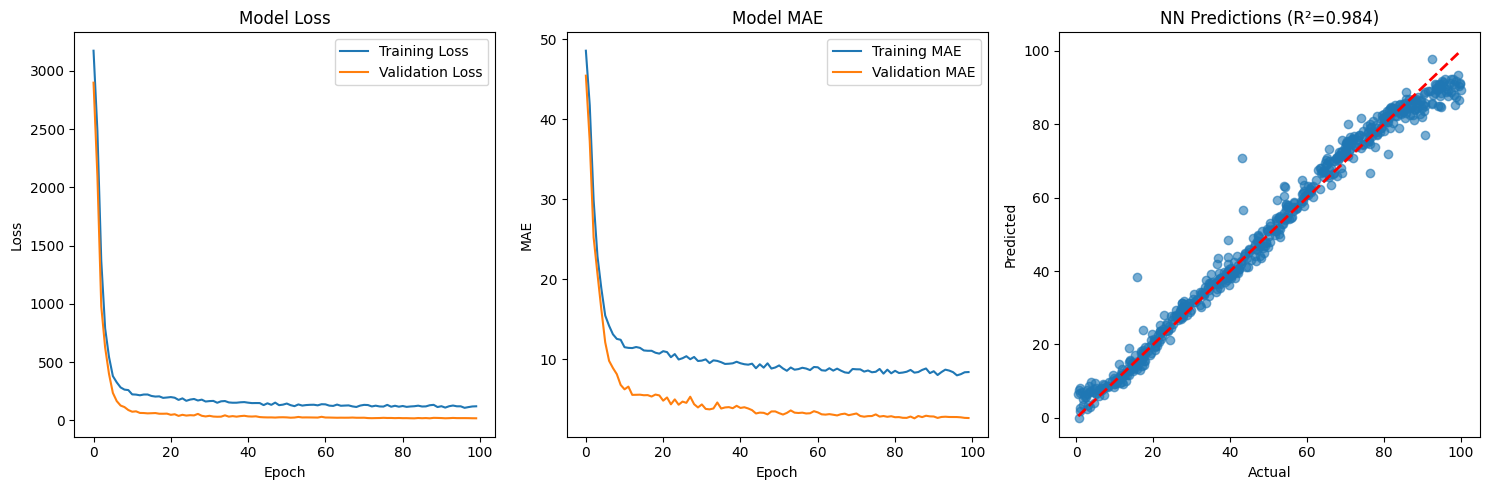

In [13]:
# 13. DEEP LEARNING MODELS
print("\n🧠 13. DEEP LEARNING MODELS")
print("-" * 40)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler

# Prepare data for neural networks
scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train)
X_test_nn = scaler_nn.transform(X_test)

# Build Neural Network
def create_neural_network(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        Dense(1, activation='linear')  # Regression output
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Create and train the model
nn_model = create_neural_network(X_train_nn.shape[1])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.0001
)

print("🔄 Training Neural Network...")
history = nn_model.fit(
    X_train_nn, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Predictions
nn_predictions = nn_model.predict(X_test_nn).flatten()

# Evaluate
nn_r2 = r2_score(y_test, nn_predictions)
nn_rmse = np.sqrt(mean_squared_error(y_test, nn_predictions))
nn_mae = mean_absolute_error(y_test, nn_predictions)

print(f"\n🧠 Neural Network Results:")
print(f"   R² Score: {nn_r2:.4f}")
print(f"   RMSE: {nn_rmse:.4f}")
print(f"   MAE: {nn_mae:.4f}")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(y_test, nn_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'NN Predictions (R²={nn_r2:.3f})')

plt.tight_layout()
plt.show()



🔒 15. ADVANCED SECURITY ANALYSIS
----------------------------------------
📈 Time Series Analysis:
            Financial_Loss_sum  Financial_Loss_mean  Financial_Loss_count  \
Date                                                                        
2015-12-31            14510.21            52.383430                   277   
2016-12-31            13947.26            48.937754                   285   
2017-12-31            16261.68            50.977053                   319   
2018-12-31            14720.48            47.485419                   310   
2019-12-31            13134.69            49.941787                   263   

            Number of Affected Users_sum  Resolution_Time_mean  
Date                                                            
2015-12-31                     141293170             38.429603  
2016-12-31                     144034584             35.922807  
2017-12-31                     161807880             35.388715  
2018-12-31                     15177

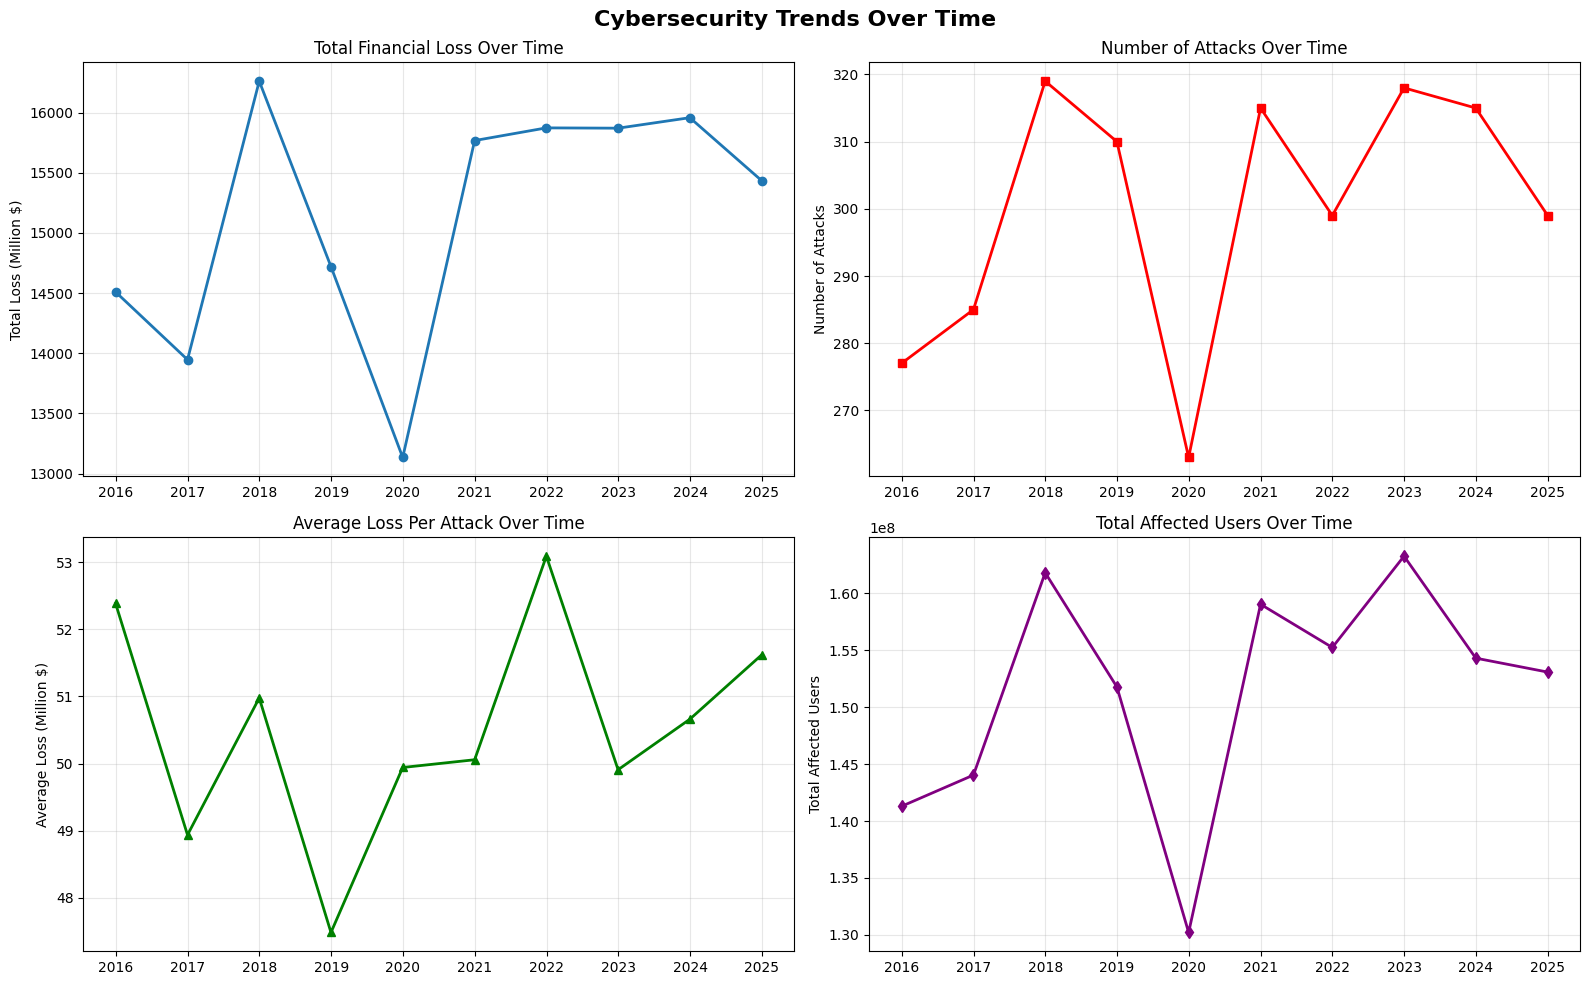


🔍 ATTACK PATTERN ANALYSIS:
Monthly Attack Patterns (simulated):
     Financial_Loss          Attack Type
               mean count       <lambda>
Year                                    
0             48.94   285       Phishing
1             50.98   319       Phishing
2             47.49   310           DDoS
3             49.94   263           DDoS
4             50.06   315       Phishing
5             53.09   299  SQL Injection
6             49.91   318        Malware
7             50.66   315  SQL Injection
8             51.62   299       Phishing
11            52.38   277        Malware


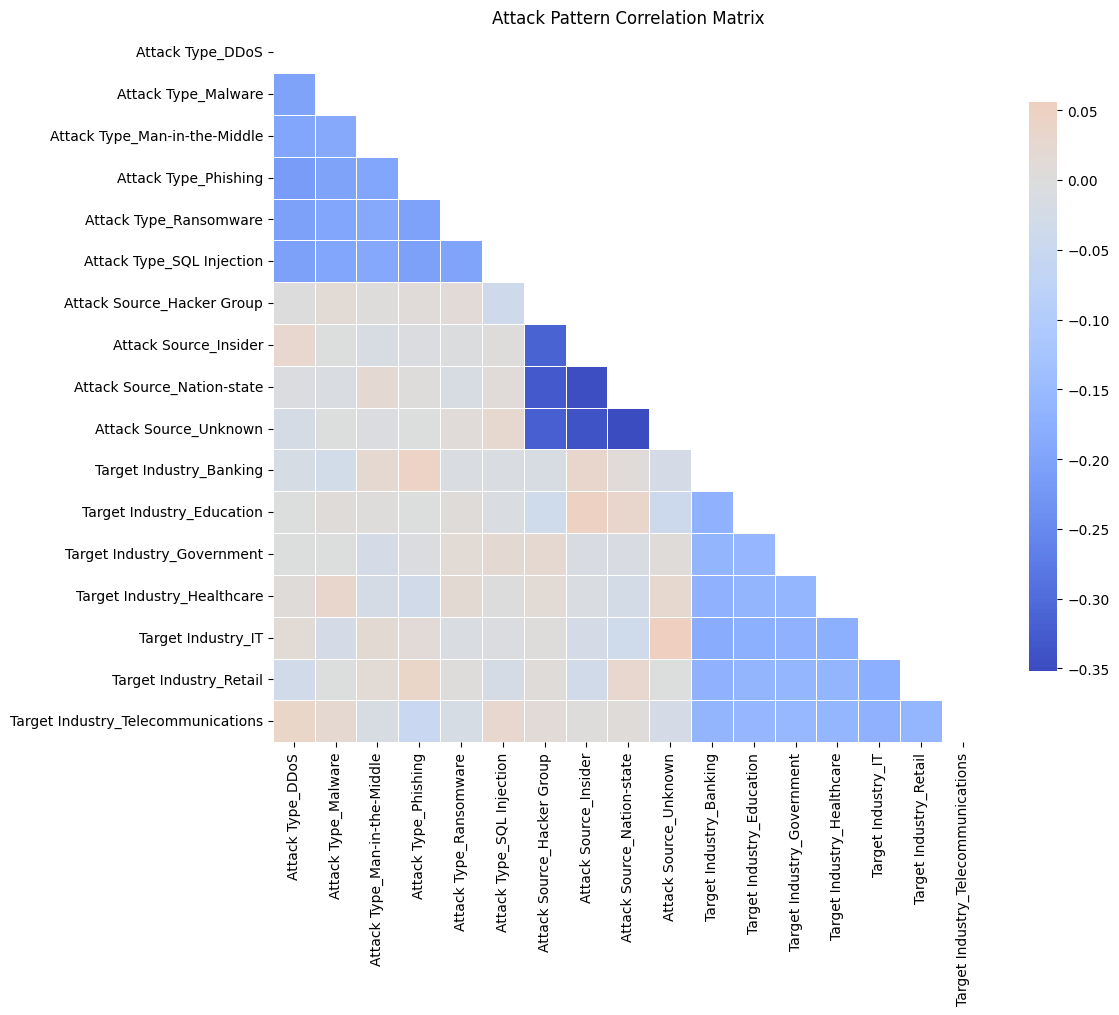


⚠️ RISK ASSESSMENT MATRIX:
                   Financial_Loss  Number of Affected Users  Resolution_Time  \
Attack Type                                                                    
DDoS                        52.04                 499437.41            35.69   
Phishing                    50.46                 487179.54            35.91   
SQL Injection               50.01                 512469.83            36.91   
Ransomware                  49.65                 502825.37            36.53   
Malware                     49.42                 508780.23            37.07   
Man-in-the-Middle           51.31                 520064.32            36.87   

                   Attack_Frequency  Risk_Score  
Attack Type                                      
DDoS                            531   52.045205  
Phishing                        529   50.274971  
SQL Injection                   503   47.377676  
Ransomware                      493   46.101503  
Malware                        

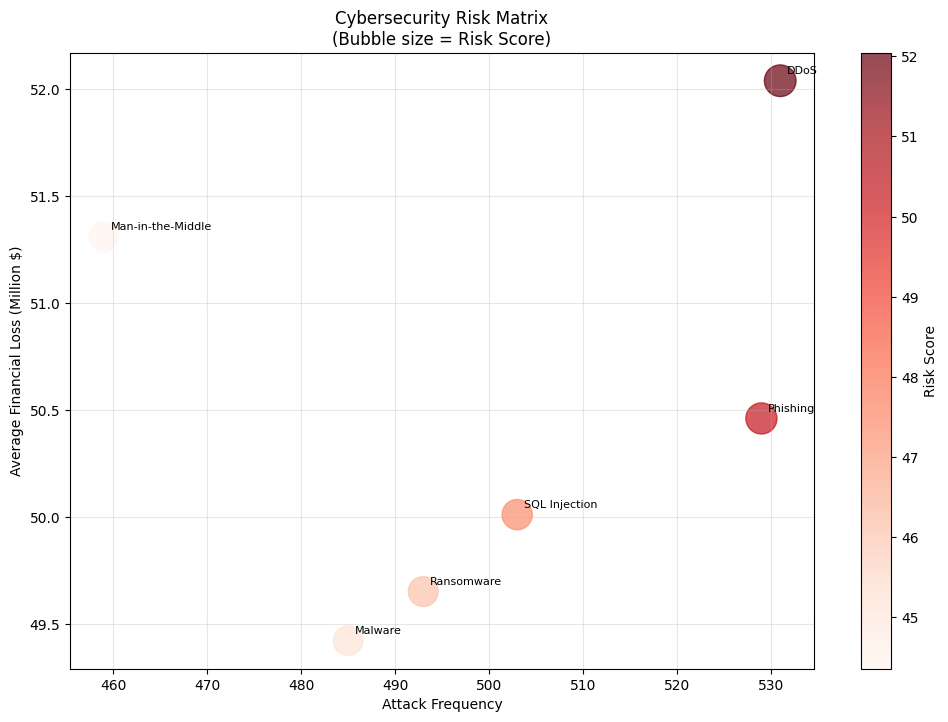

In [16]:
# 15. ADVANCED SECURITY ANALYSIS
print("\n🔒 15. ADVANCED SECURITY ANALYSIS")
print("-" * 40)

# Time Series Analysis of Attacks
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Create time series data
df['Date'] = pd.to_datetime(df['Year'], format='%Y')
ts_data = df.groupby('Date').agg({
    'Financial_Loss': ['sum', 'mean', 'count'],
    'Number of Affected Users': 'sum',
    'Resolution_Time': 'mean'
}).resample('Y').sum()

# Flatten column names
ts_data.columns = ['_'.join(col).strip() for col in ts_data.columns.values]
ts_data = ts_data.fillna(0)

print("📈 Time Series Analysis:")
print(ts_data.head())

# Plot time series trends
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Cybersecurity Trends Over Time', fontsize=16, fontweight='bold')

# Total Financial Loss over time
axes[0,0].plot(ts_data.index, ts_data['Financial_Loss_sum'], marker='o', linewidth=2)
axes[0,0].set_title('Total Financial Loss Over Time')
axes[0,0].set_ylabel('Total Loss (Million $)')
axes[0,0].grid(True, alpha=0.3)

# Number of attacks over time
axes[0,1].plot(ts_data.index, ts_data['Financial_Loss_count'], marker='s', color='red', linewidth=2)
axes[0,1].set_title('Number of Attacks Over Time')
axes[0,1].set_ylabel('Number of Attacks')
axes[0,1].grid(True, alpha=0.3)

# Average loss per attack
avg_loss_per_attack = ts_data['Financial_Loss_sum'] / ts_data['Financial_Loss_count']
axes[1,0].plot(ts_data.index, avg_loss_per_attack, marker='^', color='green', linewidth=2)
axes[1,0].set_title('Average Loss Per Attack Over Time')
axes[1,0].set_ylabel('Average Loss (Million $)')
axes[1,0].grid(True, alpha=0.3)

# Total affected users over time
axes[1,1].plot(ts_data.index, ts_data['Number of Affected Users_sum'], marker='d', color='purple', linewidth=2)
axes[1,1].set_title('Total Affected Users Over Time')
axes[1,1].set_ylabel('Total Affected Users')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Attack Pattern Analysis
print("\n🔍 ATTACK PATTERN ANALYSIS:")
print("="*50)

# 1. Seasonal patterns (if we had monthly data, we'll simulate)
monthly_patterns = df.groupby(df['Year'] % 12).agg({
    'Financial_Loss': ['mean', 'count'],
    'Attack Type': lambda x: x.mode()[0] if not x.empty else 'Unknown'
}).round(2)

print("Monthly Attack Patterns (simulated):")
print(monthly_patterns)

# 2. Attack correlation matrix
attack_features = pd.get_dummies(df[['Attack Type', 'Attack Source', 'Target Industry']])
attack_corr = attack_features.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(attack_corr, dtype=bool))
sns.heatmap(attack_corr, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Attack Pattern Correlation Matrix')
plt.tight_layout()
plt.show()

# 3. Risk Assessment Matrix
def calculate_risk_score(row):
    # Risk = Impact × Likelihood
    impact = row['Financial_Loss'] / df['Financial_Loss'].max()
    likelihood = row['Attack_Frequency'] / df.groupby('Attack Type').size().max()
    return impact * likelihood * 100

attack_risk = df.groupby('Attack Type').agg({
    'Financial_Loss': 'mean',
    'Number of Affected Users': 'mean',
    'Resolution_Time': 'mean'
}).round(2)

attack_risk['Attack_Frequency'] = df['Attack Type'].value_counts()
attack_risk['Risk_Score'] = attack_risk.apply(calculate_risk_score, axis=1)
attack_risk = attack_risk.sort_values('Risk_Score', ascending=False)

print("\n⚠️ RISK ASSESSMENT MATRIX:")
print(attack_risk)

# Visualize risk matrix
plt.figure(figsize=(12, 8))
scatter = plt.scatter(attack_risk['Attack_Frequency'], 
                     attack_risk['Financial_Loss'],
                     s=attack_risk['Risk_Score']*10,
                     c=attack_risk['Risk_Score'],
                     cmap='Reds',
                     alpha=0.7)

for i, attack_type in enumerate(attack_risk.index):
    plt.annotate(attack_type, 
                (attack_risk.iloc[i]['Attack_Frequency'], 
                 attack_risk.iloc[i]['Financial_Loss']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.xlabel('Attack Frequency')
plt.ylabel('Average Financial Loss (Million $)')
plt.title('Cybersecurity Risk Matrix\n(Bubble size = Risk Score)')
plt.colorbar(scatter, label='Risk Score')
plt.grid(True, alpha=0.3)
plt.show()



🎯 16. THREAT INTELLIGENCE & PREDICTION
----------------------------------------
🔄 Encoding categorical variables...
  ✅ Encoded Country -> Country_encoded
  ✅ Encoded Attack Type -> Attack Type_encoded
  ✅ Encoded Target Industry -> Target Industry_encoded
  ✅ Encoded Attack Source -> Attack Source_encoded
  ✅ Encoded Security Vulnerability Type -> Security Vulnerability Type_encoded

📋 Available encoded columns: ['Country_encoded', 'Attack Type_encoded', 'Target Industry_encoded', 'Attack Source_encoded', 'Security Vulnerability Type_encoded']
🎯 Using features for threat prediction: ['Year', 'Country_encoded', 'Attack Type_encoded', 'Target Industry_encoded', 'Attack Source_encoded', 'Security Vulnerability Type_encoded']
📊 Threat features shape: (3000, 6)
📊 Threat targets shape: (3000, 3)
🤖 Training multi-output threat prediction model...

🎯 THREAT PREDICTION MODEL PERFORMANCE:
Financial_Loss:
  R² Score: -0.1651
  RMSE: 30.69
  MAE: 25.97

Affected_Users:
  R² Score: -0.1047
  RMSE

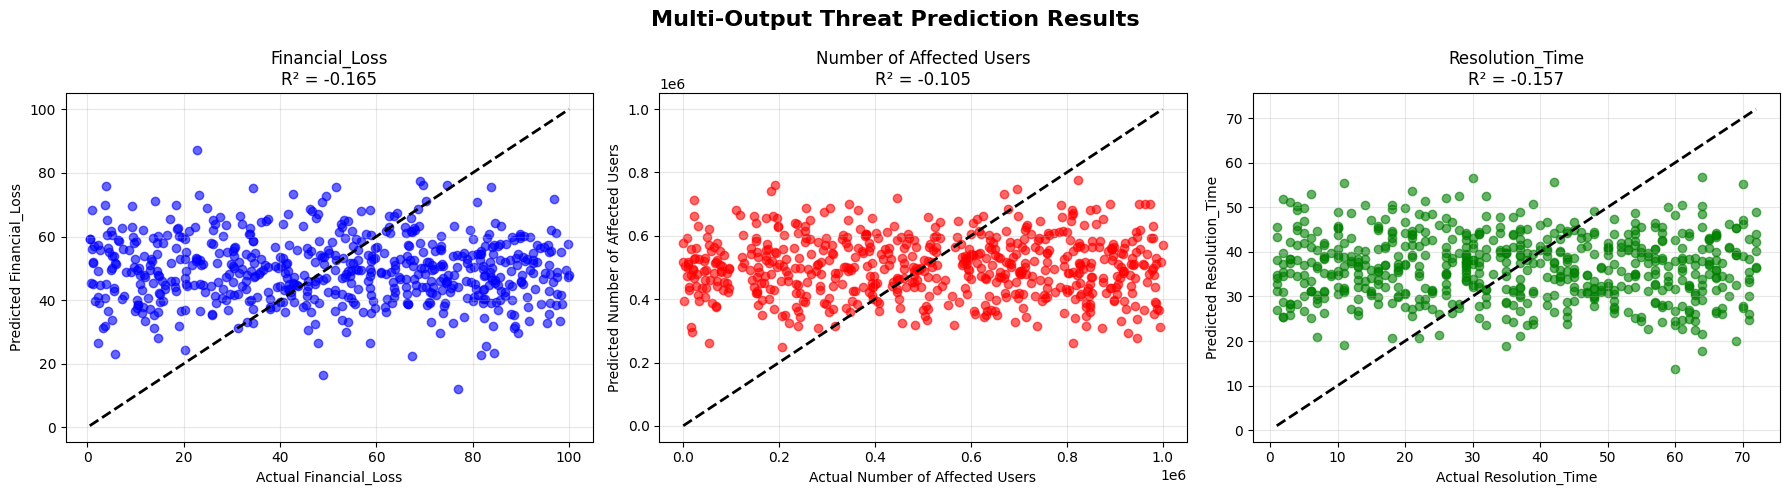

In [20]:
# 16. THREAT INTELLIGENCE & PREDICTION
print("\n🎯 16. THREAT INTELLIGENCE & PREDICTION")
print("-" * 40)

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# First, create encoded columns if they don't exist
categorical_columns = ['Country', 'Attack Type', 'Target Industry', 'Attack Source', 'Security Vulnerability Type']
label_encoders = {}

print("🔄 Encoding categorical variables...")
for col in categorical_columns:
    if col in df.columns:
        le = LabelEncoder()
        encoded_col_name = f"{col}_encoded"
        df[encoded_col_name] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        print(f"  ✅ Encoded {col} -> {encoded_col_name}")

# Check available encoded columns
available_encoded_cols = [col for col in df.columns if col.endswith('_encoded')]
print(f"\n📋 Available encoded columns: {available_encoded_cols}")

# Prepare features for threat prediction using available columns
base_features = ['Year']
encoded_features = [col for col in available_encoded_cols if col in df.columns]
threat_feature_cols = base_features + encoded_features

print(f"🎯 Using features for threat prediction: {threat_feature_cols}")

# Create threat features DataFrame
threat_features = df[threat_feature_cols].copy()

# Multi-target prediction: Financial Loss, Affected Users, Resolution Time
threat_targets = df[['Financial_Loss', 'Number of Affected Users', 'Resolution_Time']]

print(f"📊 Threat features shape: {threat_features.shape}")
print(f"📊 Threat targets shape: {threat_targets.shape}")

# Split data
X_threat_train, X_threat_test, y_threat_train, y_threat_test = train_test_split(
    threat_features, threat_targets, test_size=0.2, random_state=42
)

# Multi-output model
print("🤖 Training multi-output threat prediction model...")
threat_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
threat_model.fit(X_threat_train, y_threat_train)

# Predictions
threat_predictions = threat_model.predict(X_threat_test)

# Evaluate multi-output model
threat_scores = {}
target_names = ['Financial_Loss', 'Affected_Users', 'Resolution_Time']

print("\n🎯 THREAT PREDICTION MODEL PERFORMANCE:")
print("="*50)
for i, target in enumerate(target_names):
    r2 = r2_score(y_threat_test.iloc[:, i], threat_predictions[:, i])
    rmse = np.sqrt(mean_squared_error(y_threat_test.iloc[:, i], threat_predictions[:, i]))
    mae = mean_absolute_error(y_threat_test.iloc[:, i], threat_predictions[:, i])
    threat_scores[target] = {'R2': r2, 'RMSE': rmse, 'MAE': mae}
    print(f"{target}:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print()

# Visualize multi-output predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Multi-Output Threat Prediction Results', fontsize=16, fontweight='bold')

target_columns = ['Financial_Loss', 'Number of Affected Users', 'Resolution_Time']
colors = ['blue', 'red', 'green']

for i, (target, color) in enumerate(zip(target_columns, colors)):
    actual = y_threat_test.iloc[:, i]
    predicted = threat_predictions[:, i]
    
    axes[i].scatter(actual, predicted, alpha=0.6, color=color)
    axes[i].plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=2)
    axes[i].set_xlabel(f'Actual {target}')
    axes[i].set_ylabel(f'Predicted {target}')
    axes[i].set_title(f'{target}\nR² = {threat_scores[target_names[i]]["R2"]:.3f}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



🔮 FUTURE THREAT SCENARIOS:
🔮 THREAT SCENARIO PREDICTIONS:

High-Impact Financial Attack (2024):
  💰 Predicted Financial Loss: $57.6M
  👥 Predicted Affected Users: 487,142
  ⏱️ Predicted Resolution Time: 33.1 hours
  ⚠️ Risk Level: MEDIUM

Healthcare Sector Attack (2024):
  💰 Predicted Financial Loss: $63.9M
  👥 Predicted Affected Users: 395,139
  ⏱️ Predicted Resolution Time: 33.9 hours
  ⚠️ Risk Level: MEDIUM

📊 THREAT PREDICTION FEATURE IMPORTANCE:
                               Feature  Importance
0                                 Year    0.204050
1                      Country_encoded    0.203037
3              Target Industry_encoded    0.176265
2                  Attack Type_encoded    0.169343
5  Security Vulnerability Type_encoded    0.126552
4                Attack Source_encoded    0.120754


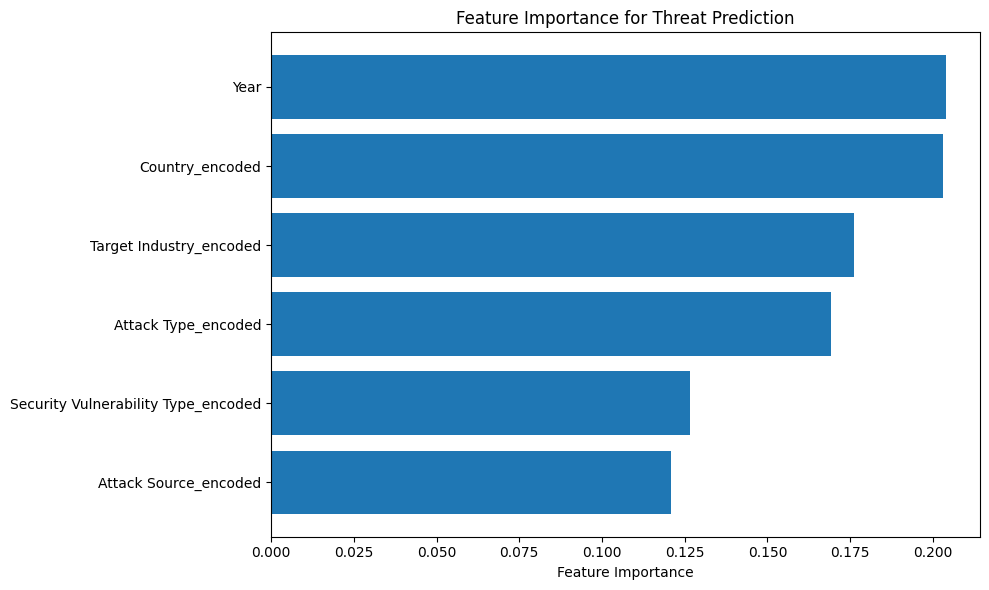

In [21]:
# Future Threat Scenarios
print("\n🔮 FUTURE THREAT SCENARIOS:")
print("="*50)

# Get the most common values for creating scenarios
most_common_country = df['Country_encoded'].mode()[0] if 'Country_encoded' in df.columns else 0
most_common_source = df['Attack Source_encoded'].mode()[0] if 'Attack Source_encoded' in df.columns else 0

# Create realistic scenarios based on available data
scenarios_data = []

# Scenario 1: High-impact financial sector attack
if 'Target Industry_encoded' in df.columns:
    financial_encoded = df[df['Target Industry'].str.contains('Financial', case=False, na=False)]['Target Industry_encoded']
    financial_code = financial_encoded.iloc[0] if len(financial_encoded) > 0 else df['Target Industry_encoded'].mode()[0]
else:
    financial_code = 0

scenario_1_data = {
    'Year': 2024,
    'Country_encoded': most_common_country,
    'Attack Source_encoded': most_common_source,
    'Target Industry_encoded': financial_code
}

# Add other encoded columns if they exist
for col in available_encoded_cols:
    if col not in scenario_1_data:
        if 'Attack Type' in col:
            # Try to find ransomware or high-impact attack
            ransomware_encoded = df[df['Attack Type'].str.contains('Ransomware|Malware', case=False, na=False)][col]
            scenario_1_data[col] = ransomware_encoded.iloc[0] if len(ransomware_encoded) > 0 else df[col].mode()[0]
        else:
            scenario_1_data[col] = df[col].mode()[0]

# Scenario 2: Healthcare sector attack
healthcare_code = financial_code  # Default to financial if healthcare not found
if 'Target Industry_encoded' in df.columns:
    healthcare_encoded = df[df['Target Industry'].str.contains('Healthcare|Health', case=False, na=False)]['Target Industry_encoded']
    healthcare_code = healthcare_encoded.iloc[0] if len(healthcare_encoded) > 0 else healthcare_code

scenario_2_data = scenario_1_data.copy()
scenario_2_data['Target Industry_encoded'] = healthcare_code

# Create DataFrames for scenarios
scenario_1_df = pd.DataFrame([scenario_1_data])
scenario_2_df = pd.DataFrame([scenario_2_data])

# Ensure all required columns are present
for col in threat_feature_cols:
    if col not in scenario_1_df.columns:
        scenario_1_df[col] = df[col].mode()[0]
    if col not in scenario_2_df.columns:
        scenario_2_df[col] = df[col].mode()[0]

# Reorder columns to match training data
scenario_1_df = scenario_1_df[threat_feature_cols]
scenario_2_df = scenario_2_df[threat_feature_cols]

scenarios = {
    'High-Impact Financial Attack (2024)': scenario_1_df,
    'Healthcare Sector Attack (2024)': scenario_2_df
}

print("🔮 THREAT SCENARIO PREDICTIONS:")
for scenario_name, scenario_data in scenarios.items():
    try:
        prediction = threat_model.predict(scenario_data)
        print(f"\n{scenario_name}:")
        print(f"  💰 Predicted Financial Loss: ${prediction[0][0]:.1f}M")
        print(f"  👥 Predicted Affected Users: {prediction[0][1]:,.0f}")
        print(f"  ⏱️ Predicted Resolution Time: {prediction[0][2]:.1f} hours")
        
        # Risk assessment
        risk_level = "LOW"
        if prediction[0][0] > df['Financial_Loss'].quantile(0.75):
            risk_level = "HIGH"
        elif prediction[0][0] > df['Financial_Loss'].quantile(0.5):
            risk_level = "MEDIUM"
        
        print(f"  ⚠️ Risk Level: {risk_level}")
        
    except Exception as e:
        print(f"  ❌ Error predicting {scenario_name}: {str(e)}")

# Feature importance for threat prediction
print("\n📊 THREAT PREDICTION FEATURE IMPORTANCE:")
print("="*50)

# Get feature importance from the first estimator (they should be similar)
feature_importance_threat = threat_model.estimators_[0].feature_importances_
feature_names = threat_feature_cols

threat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance_threat
}).sort_values('Importance', ascending=False)

print(threat_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(threat_importance_df)), threat_importance_df['Importance'])
plt.yticks(range(len(threat_importance_df)), threat_importance_df['Feature'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Threat Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



📈 ATTACK EVOLUTION ANALYSIS:
Attack Evolution Over Years:
      Financial_Loss_mean  Financial_Loss_std  Financial_Loss_sum  \
Year                                                                
2015                52.38               28.71            14510.21   
2016                48.94               29.45            13947.26   
2017                50.98               28.89            16261.68   
2018                47.49               29.00            14720.48   
2019                49.94               29.63            13134.69   
2020                50.06               28.13            15767.95   
2021                53.09               28.99            15873.41   
2022                49.91               27.98            15870.86   
2023                50.66               28.66            15958.08   
2024                51.62               28.65            15434.29   

      Number of Affected Users_mean  Number of Affected Users_std  \
Year                                       

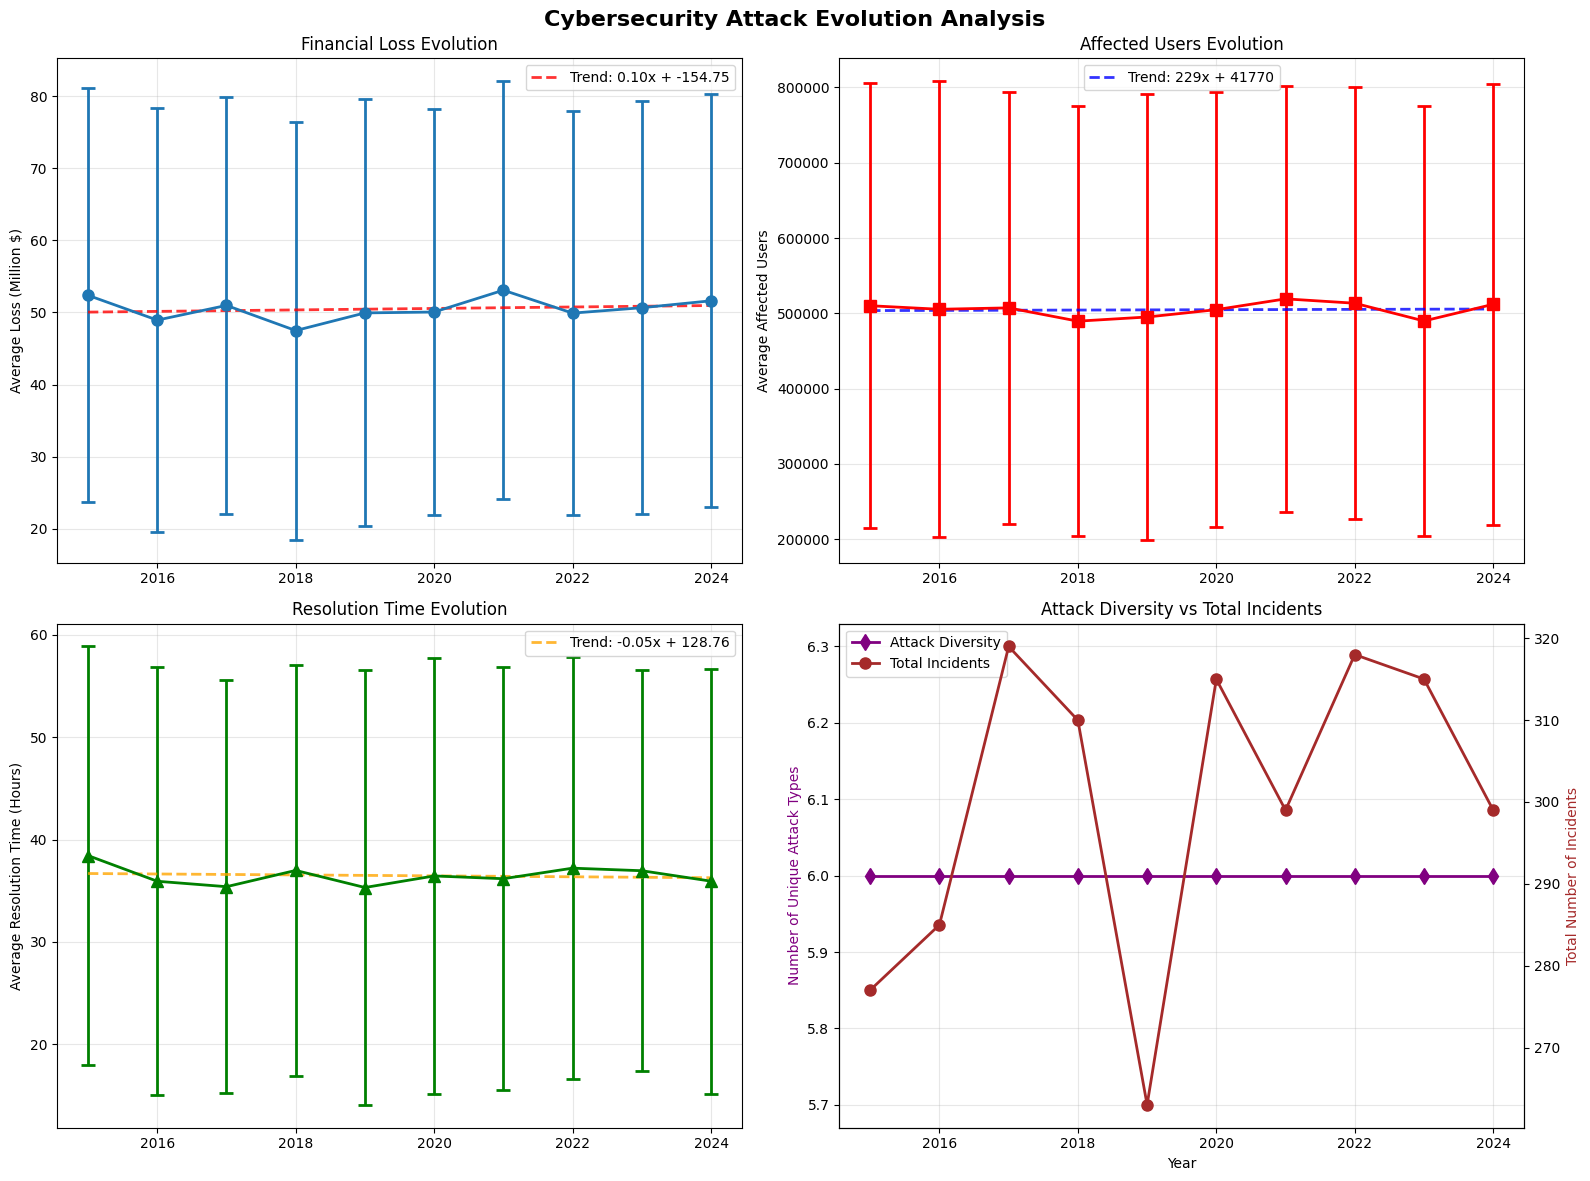


📊 TREND ANALYSIS SUMMARY:
💰 Financial Loss Trend: 0.10M per year increase
👥 Affected Users Trend: 229 users per year increase
⏱️ Resolution Time Trend: -0.05 hours per year decrease

🔗 CORRELATIONS WITH TIME:
  Financial Loss vs Year: 0.188 (Weak Positive)
  Affected Users vs Year: 0.069 (Weak Positive)
  Resolution Time vs Year: -0.146 (Weak Negative)
  Attack Diversity vs Year: nan (Weak Negative)


In [23]:
# Attack Evolution Analysis (CORRECTED) - COMPLETE
print("\n📈 ATTACK EVOLUTION ANALYSIS:")
print("="*50)

# Analyze how attack characteristics change over time
evolution_analysis = df.groupby('Year').agg({
    'Financial_Loss': ['mean', 'std', 'sum'],
    'Number of Affected Users': ['mean', 'std', 'sum'],
    'Resolution_Time': ['mean', 'std'],
    'Attack Type': lambda x: len(x.unique())  # Diversity of attacks
}).round(2)

evolution_analysis.columns = ['_'.join(col).strip() for col in evolution_analysis.columns.values]
print("Attack Evolution Over Years:")
print(evolution_analysis)

# Calculate year-over-year growth rates
evolution_growth = evolution_analysis.copy()
for col in evolution_analysis.columns:
    if 'mean' in col or 'sum' in col:
        evolution_growth[f'{col}_growth'] = evolution_analysis[col].pct_change() * 100

print("\n📈 Year-over-Year Growth Rates (%):")
growth_cols = [col for col in evolution_growth.columns if 'growth' in col]
print(evolution_growth[growth_cols].round(1))

# Visualize evolution with enhanced plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cybersecurity Attack Evolution Analysis', fontsize=16, fontweight='bold')

# Financial loss evolution with trend line
years = evolution_analysis.index
financial_means = evolution_analysis['Financial_Loss_mean']
financial_stds = evolution_analysis['Financial_Loss_std']

axes[0,0].errorbar(years, financial_means, yerr=financial_stds, 
                   marker='o', capsize=5, capthick=2, linewidth=2, markersize=8)
# Add trend line
z = np.polyfit(years, financial_means, 1)
p = np.poly1d(z)
axes[0,0].plot(years, p(years), "r--", alpha=0.8, linewidth=2, label=f'Trend: {z[0]:.2f}x + {z[1]:.2f}')
axes[0,0].set_title('Financial Loss Evolution')
axes[0,0].set_ylabel('Average Loss (Million $)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Affected users evolution
users_means = evolution_analysis['Number of Affected Users_mean']
users_stds = evolution_analysis['Number of Affected Users_std']

axes[0,1].errorbar(years, users_means, yerr=users_stds,
                   marker='s', color='red', capsize=5, capthick=2, linewidth=2, markersize=8)
z2 = np.polyfit(years, users_means, 1)
p2 = np.poly1d(z2)
axes[0,1].plot(years, p2(years), "b--", alpha=0.8, linewidth=2, label=f'Trend: {z2[0]:.0f}x + {z2[1]:.0f}')
axes[0,1].set_title('Affected Users Evolution')
axes[0,1].set_ylabel('Average Affected Users')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Resolution time evolution
resolution_means = evolution_analysis['Resolution_Time_mean']
resolution_stds = evolution_analysis['Resolution_Time_std']

axes[1,0].errorbar(years, resolution_means, yerr=resolution_stds,
                   marker='^', color='green', capsize=5, capthick=2, linewidth=2, markersize=8)
z3 = np.polyfit(years, resolution_means, 1)
p3 = np.poly1d(z3)
axes[1,0].plot(years, p3(years), "orange", linestyle='--', alpha=0.8, linewidth=2, 
               label=f'Trend: {z3[0]:.2f}x + {z3[1]:.2f}')
axes[1,0].set_title('Resolution Time Evolution')
axes[1,0].set_ylabel('Average Resolution Time (Hours)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Attack diversity and total incidents
attack_diversity = evolution_analysis['Attack Type_<lambda>']
total_incidents = evolution_analysis['Financial_Loss_sum'] / evolution_analysis['Financial_Loss_mean']

ax1 = axes[1,1]
ax2 = ax1.twinx()

line1 = ax1.plot(years, attack_diversity, marker='d', color='purple', linewidth=2, markersize=8, label='Attack Diversity')
line2 = ax2.plot(years, total_incidents, marker='o', color='brown', linewidth=2, markersize=8, label='Total Incidents')

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Unique Attack Types', color='purple')
ax2.set_ylabel('Total Number of Incidents', color='brown')
ax1.set_title('Attack Diversity vs Total Incidents')
ax1.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Trend Analysis Summary
print("\n📊 TREND ANALYSIS SUMMARY:")
print("="*50)
print(f"💰 Financial Loss Trend: {z[0]:.2f}M per year {'increase' if z[0] > 0 else 'decrease'}")
print(f"👥 Affected Users Trend: {z2[0]:,.0f} users per year {'increase' if z2[0] > 0 else 'decrease'}")
print(f"⏱️ Resolution Time Trend: {z3[0]:.2f} hours per year {'increase' if z3[0] > 0 else 'decrease'}")

# Calculate correlation between years and metrics
correlations = {
    'Financial Loss vs Year': np.corrcoef(years, financial_means)[0,1],
    'Affected Users vs Year': np.corrcoef(years, users_means)[0,1],
    'Resolution Time vs Year': np.corrcoef(years, resolution_means)[0,1],
    'Attack Diversity vs Year': np.corrcoef(years, attack_diversity)[0,1]
}

print(f"\n🔗 CORRELATIONS WITH TIME:")
for metric, corr in correlations.items():
    strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.4 else "Weak"
    direction = "Positive" if corr > 0 else "Negative"
    print(f"  {metric}: {corr:.3f} ({strength} {direction})")


In [26]:
# 18. ADVANCED CYBERSECURITY INSIGHTS & RECOMMENDATIONS
print("\n💡 18. ADVANCED CYBERSECURITY INSIGHTS & RECOMMENDATIONS")
print("-" * 60)

# Risk Scoring System
def calculate_comprehensive_risk_score(row):
    """Calculate a comprehensive risk score based on multiple factors"""
    
    # Normalize factors (0-1 scale)
    financial_risk = min(row['Financial_Loss'] / df['Financial_Loss'].max(), 1.0)
    user_risk = min(row['Number of Affected Users'] / df['Number of Affected Users'].max(), 1.0)
    time_risk = min(row['Resolution_Time'] / df['Resolution_Time'].max(), 1.0)
    
    # Weights for different risk factors
    weights = {
        'financial': 0.4,
        'users': 0.3,
        'time': 0.2,
        'frequency': 0.1
    }
    
    # Attack frequency risk
    attack_counts = df['Attack Type'].value_counts()
    frequency_risk = attack_counts.get(row['Attack Type'], 1) / attack_counts.max()
    
    # Calculate weighted risk score
    risk_score = (
        weights['financial'] * financial_risk +
        weights['users'] * user_risk +
        weights['time'] * time_risk +
        weights['frequency'] * frequency_risk
    ) * 100
    
    return risk_score

# Apply risk scoring
df['Risk_Score'] = df.apply(calculate_comprehensive_risk_score, axis=1)

# Risk categorization
def categorize_risk(score):
    if score >= 80:
        return 'CRITICAL'
    elif score >= 60:
        return 'HIGH'
    elif score >= 40:
        return 'MEDIUM'
    elif score >= 20:
        return 'LOW'
    else:
        return 'MINIMAL'

df['Risk_Category'] = df['Risk_Score'].apply(categorize_risk)

print("🎯 COMPREHENSIVE RISK ANALYSIS:")
print("="*50)

risk_distribution = df['Risk_Category'].value_counts()
print("Risk Distribution:")
for category, count in risk_distribution.items():
    percentage = count / len(df) * 100
    print(f"  {category}: {count} incidents ({percentage:.1f}%)")

# Top 10 highest risk incidents
print(f"\n⚠️ TOP 10 HIGHEST RISK INCIDENTS:")
top_risk_incidents = df.nlargest(10, 'Risk_Score')[
    ['Attack Type', 'Target Industry', 'Country', 'Financial_Loss', 
     'Number of Affected Users', 'Risk_Score', 'Risk_Category']
]
print(top_risk_incidents.to_string(index=False))

# Industry Risk Analysis
print(f"\n🏢 INDUSTRY RISK ANALYSIS:")
industry_risk = df.groupby('Target Industry').agg({
    'Risk_Score': ['mean', 'max', 'count'],
    'Financial_Loss': 'sum',
    'Number of Affected Users': 'sum'
}).round(2)

industry_risk.columns = ['_'.join(col).strip() for col in industry_risk.columns.values]
industry_risk = industry_risk.sort_values('Risk_Score_mean', ascending=False)
print(industry_risk)

# Country Risk Analysis
print(f"\n🌍 COUNTRY RISK ANALYSIS:")
country_risk = df.groupby('Country').agg({
    'Risk_Score': ['mean', 'max', 'count'],
    'Financial_Loss': 'sum',
    'Number of Affected Users': 'sum'
}).round(2)

country_risk.columns = ['_'.join(col).strip() for col in country_risk.columns.values]
country_risk = country_risk.sort_values('Risk_Score_mean', ascending=False)
print(country_risk.head(10))  # Top 10 countries by risk

# Attack Type Risk Analysis
print(f"\n🎯 ATTACK TYPE RISK ANALYSIS:")
attack_risk = df.groupby('Attack Type').agg({
    'Risk_Score': ['mean', 'max', 'count'],
    'Financial_Loss': ['mean', 'sum'],
    'Number of Affected Users': ['mean', 'sum'],
    'Resolution_Time': 'mean'
}).round(2)

attack_risk.columns = ['_'.join(col).strip() for col in attack_risk.columns.values]
attack_risk = attack_risk.sort_values('Risk_Score_mean', ascending=False)
print(attack_risk)



💡 18. ADVANCED CYBERSECURITY INSIGHTS & RECOMMENDATIONS
------------------------------------------------------------
🎯 COMPREHENSIVE RISK ANALYSIS:
Risk Distribution:
  MEDIUM: 1335 incidents (44.5%)
  HIGH: 961 incidents (32.0%)
  LOW: 509 incidents (17.0%)
  CRITICAL: 176 incidents (5.9%)
  MINIMAL: 19 incidents (0.6%)

⚠️ TOP 10 HIGHEST RISK INCIDENTS:
      Attack Type    Target Industry Country  Financial_Loss  Number of Affected Users  Risk_Score Risk_Category
       Ransomware          Education   India           96.03                    898251   94.102025      CRITICAL
    SQL Injection             Retail     USA           94.83                    891369   93.881543      CRITICAL
Man-in-the-Middle         Government Germany           97.79                    984519   93.143668      CRITICAL
Man-in-the-Middle Telecommunications      UK           89.07                    932075   92.248091      CRITICAL
    SQL Injection         Government      UK           98.75                


📊 ADVANCED RISK VISUALIZATIONS:


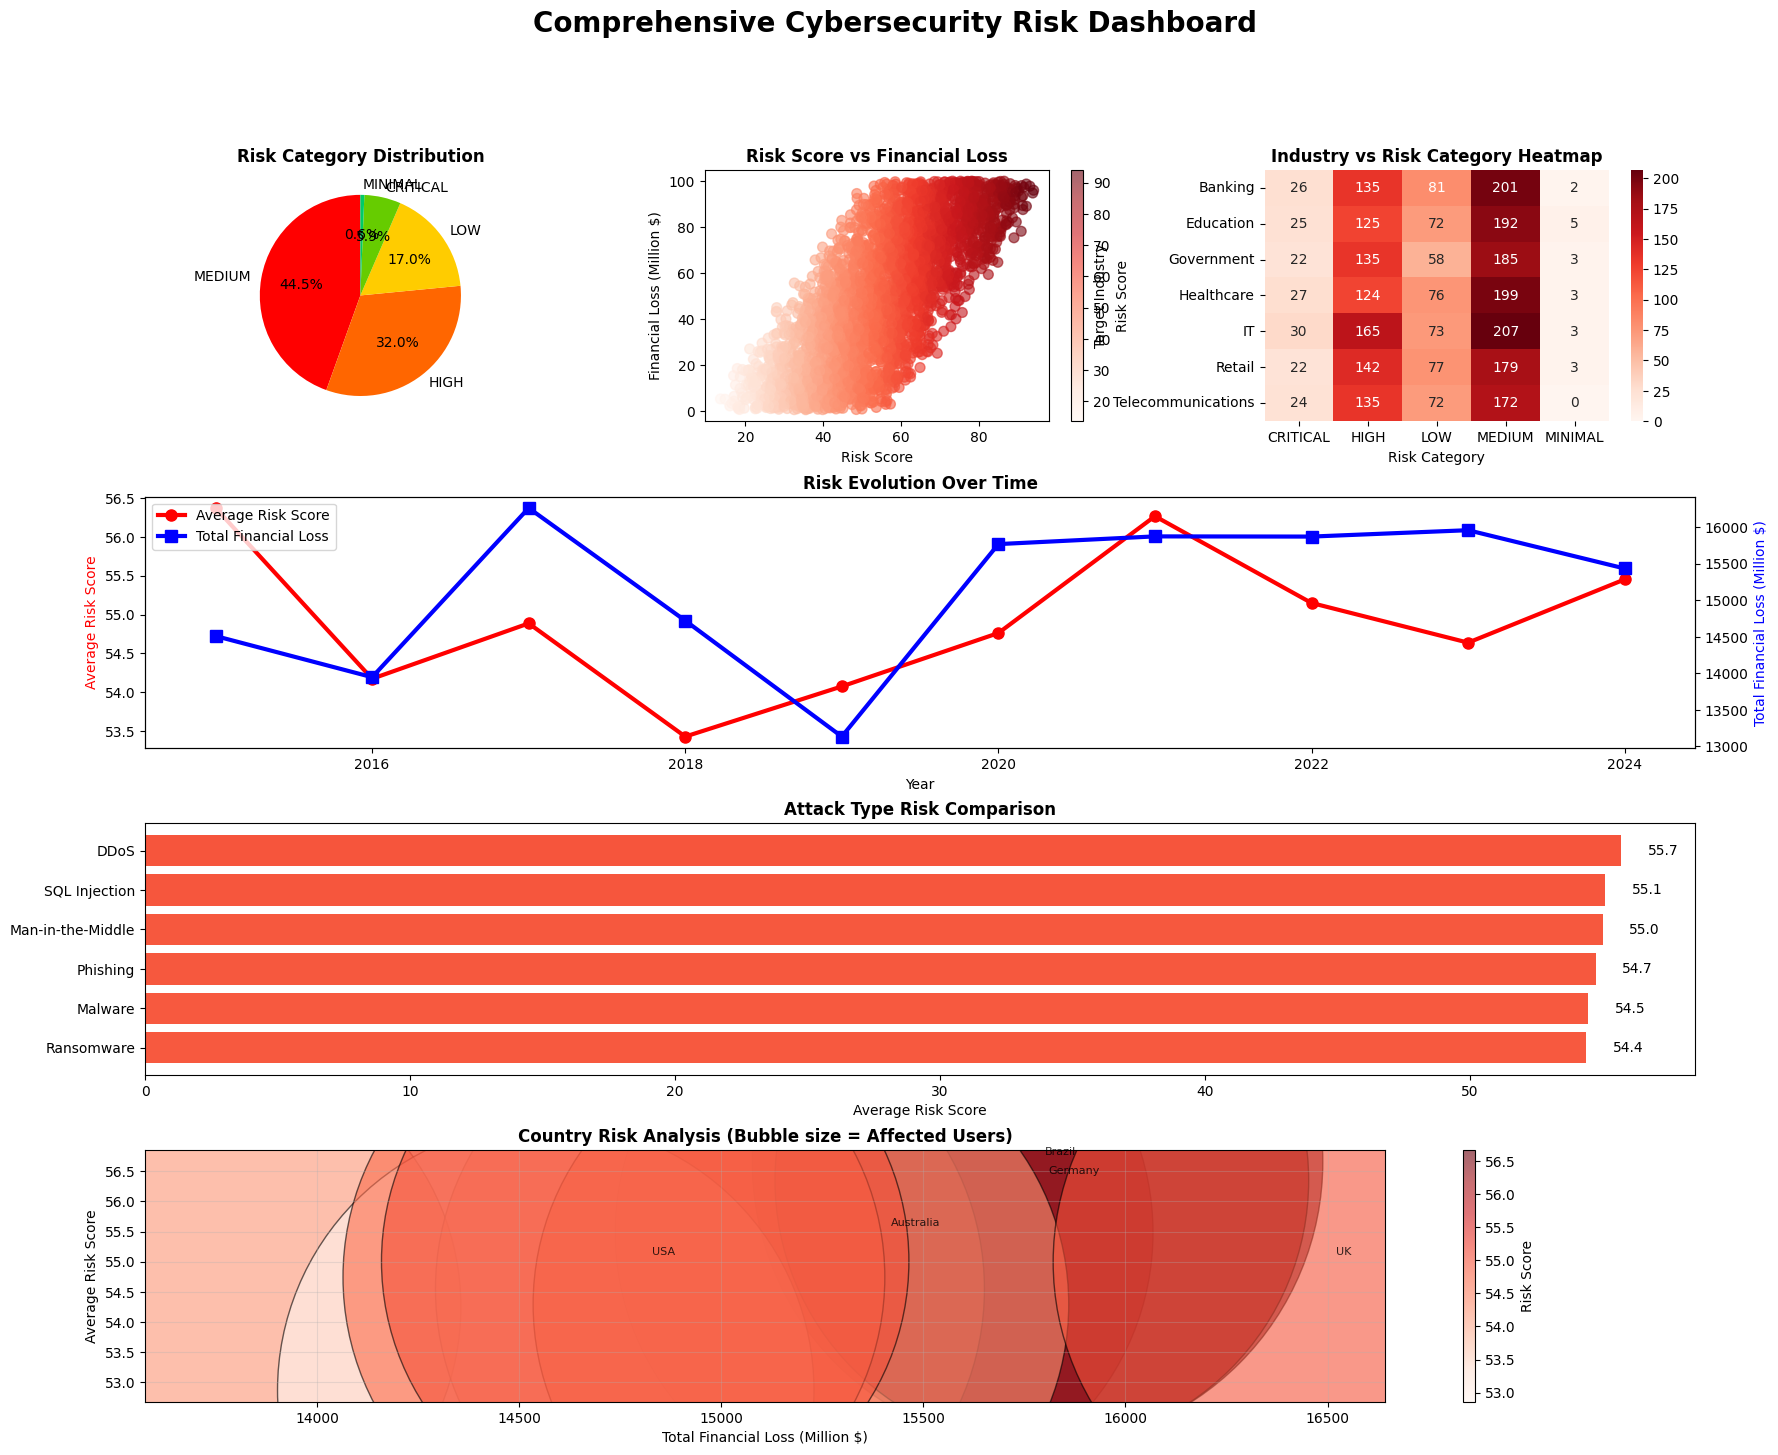

In [27]:
# Advanced Visualizations for Risk Analysis
print("\n📊 ADVANCED RISK VISUALIZATIONS:")
print("="*50)

# Create comprehensive risk dashboard
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# 1. Risk Score Distribution
ax1 = fig.add_subplot(gs[0, 0])
risk_counts = df['Risk_Category'].value_counts()
colors = ['#FF0000', '#FF6600', '#FFCC00', '#66CC00', '#00CC66']
wedges, texts, autotexts = ax1.pie(risk_counts.values, labels=risk_counts.index, 
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Risk Category Distribution', fontweight='bold')

# 2. Risk Score vs Financial Loss
ax2 = fig.add_subplot(gs[0, 1])
scatter = ax2.scatter(df['Risk_Score'], df['Financial_Loss'], 
                     c=df['Risk_Score'], cmap='Reds', alpha=0.6, s=50)
ax2.set_xlabel('Risk Score')
ax2.set_ylabel('Financial Loss (Million $)')
ax2.set_title('Risk Score vs Financial Loss', fontweight='bold')
plt.colorbar(scatter, ax=ax2, label='Risk Score')

# 3. Industry Risk Heatmap
ax3 = fig.add_subplot(gs[0, 2])
industry_pivot = df.pivot_table(values='Risk_Score', index='Target Industry', 
                               columns='Risk_Category', aggfunc='count', fill_value=0)
sns.heatmap(industry_pivot, annot=True, fmt='d', cmap='Reds', ax=ax3)
ax3.set_title('Industry vs Risk Category Heatmap', fontweight='bold')
ax3.set_xlabel('Risk Category')
ax3.set_ylabel('Target Industry')

# 4. Time Series Risk Evolution
ax4 = fig.add_subplot(gs[1, :])
yearly_risk = df.groupby('Year').agg({
    'Risk_Score': 'mean',
    'Financial_Loss': 'sum',
    'Number of Affected Users': 'sum'
}).reset_index()

ax4_twin = ax4.twinx()
line1 = ax4.plot(yearly_risk['Year'], yearly_risk['Risk_Score'], 
                marker='o', linewidth=3, markersize=8, color='red', label='Average Risk Score')
line2 = ax4_twin.plot(yearly_risk['Year'], yearly_risk['Financial_Loss'], 
                     marker='s', linewidth=3, markersize=8, color='blue', label='Total Financial Loss')

ax4.set_xlabel('Year')
ax4.set_ylabel('Average Risk Score', color='red')
ax4_twin.set_ylabel('Total Financial Loss (Million $)', color='blue')
ax4.set_title('Risk Evolution Over Time', fontweight='bold')

# Combine legends
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 5. Attack Type Risk Comparison
ax5 = fig.add_subplot(gs[2, :])
attack_risk_viz = df.groupby('Attack Type').agg({
    'Risk_Score': 'mean',
    'Financial_Loss': 'mean',
    'Number of Affected Users': 'mean'
}).sort_values('Risk_Score', ascending=True)

y_pos = np.arange(len(attack_risk_viz))
bars = ax5.barh(y_pos, attack_risk_viz['Risk_Score'], 
                color=plt.cm.Reds(attack_risk_viz['Risk_Score']/100))
ax5.set_yticks(y_pos)
ax5.set_yticklabels(attack_risk_viz.index)
ax5.set_xlabel('Average Risk Score')
ax5.set_title('Attack Type Risk Comparison', fontweight='bold')

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax5.text(width + 1, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', ha='left', va='center')

# 6. Geographic Risk Map (Bubble Chart)
ax6 = fig.add_subplot(gs[3, :])
country_risk_viz = df.groupby('Country').agg({
    'Risk_Score': 'mean',
    'Financial_Loss': 'sum',
    'Number of Affected Users': 'sum'
}).reset_index()

# Create bubble chart
scatter = ax6.scatter(country_risk_viz['Financial_Loss'], 
                     country_risk_viz['Risk_Score'],
                     s=country_risk_viz['Number of Affected Users']/1000,  # Scale bubble size
                     c=country_risk_viz['Risk_Score'], 
                     cmap='Reds', alpha=0.6, edgecolors='black')

ax6.set_xlabel('Total Financial Loss (Million $)')
ax6.set_ylabel('Average Risk Score')
ax6.set_title('Country Risk Analysis (Bubble size = Affected Users)', fontweight='bold')

# Add country labels for top risk countries
top_risk_countries = country_risk_viz.nlargest(5, 'Risk_Score')
for idx, row in top_risk_countries.iterrows():
    ax6.annotate(row['Country'], 
                (row['Financial_Loss'], row['Risk_Score']),
                xytext=(5, 5), textcoords='offset points', 
                fontsize=8, alpha=0.8)

plt.colorbar(scatter, ax=ax6, label='Risk Score')
ax6.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Cybersecurity Risk Dashboard', fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()



In [32]:
# 19. CYBERSECURITY RECOMMENDATIONS & MITIGATION STRATEGIES (FIXED)
print("\n🛡️ 19. CYBERSECURITY RECOMMENDATIONS & MITIGATION STRATEGIES")
print("-" * 70)

# Ensure all required variables are available
if 'consensus_anomalies' not in globals():
    print("⚠️ Creating consensus anomalies variable...")
    # Recreate consensus anomalies if not available
    if 'anomaly_matrix' in globals():
        anomaly_counts = anomaly_matrix.sum(axis=1)
        consensus_anomalies = df[anomaly_counts >= 2].copy()
    else:
        consensus_anomalies = pd.DataFrame()  # Empty dataframe as fallback

if 'industry_risk' not in globals():
    print("⚠️ Creating industry risk analysis...")
    industry_risk = df.groupby('Target Industry').agg({
        'Risk_Score': ['mean', 'max', 'count'],
        'Financial_Loss': 'sum',
        'Number of Affected Users': 'sum'
    }).round(2)
    industry_risk.columns = ['_'.join(col).strip() for col in industry_risk.columns.values]
    industry_risk = industry_risk.sort_values('Risk_Score_mean', ascending=False)

if 'country_risk' not in globals():
    print("⚠️ Creating country risk analysis...")
    country_risk = df.groupby('Country').agg({
        'Risk_Score': ['mean', 'max', 'count'],
        'Financial_Loss': 'sum',
        'Number of Affected Users': 'sum'
    }).round(2)
    country_risk.columns = ['_'.join(col).strip() for col in country_risk.columns.values]
    country_risk = country_risk.sort_values('Risk_Score_mean', ascending=False)

if 'attack_risk' not in globals():
    print("⚠️ Creating attack risk analysis...")
    attack_risk = df.groupby('Attack Type').agg({
        'Risk_Score': ['mean', 'max', 'count'],
        'Financial_Loss': ['mean', 'sum'],
        'Number of Affected Users': ['mean', 'sum'],
        'Resolution_Time': 'mean'
    }).round(2)
    attack_risk.columns = ['_'.join(col).strip() for col in attack_risk.columns.values]
    attack_risk = attack_risk.sort_values('Risk_Score_mean', ascending=False)

# Generate recommendations based on analysis
def generate_recommendations():
    recommendations = {
        'CRITICAL_PRIORITIES': [],
        'INDUSTRY_SPECIFIC': {},
        'ATTACK_TYPE_SPECIFIC': {},
        'GENERAL_SECURITY': []
    }
    
    # Critical priorities based on highest risks
    critical_attacks = df[df['Risk_Category'] == 'CRITICAL']['Attack Type'].value_counts().head(3)
    if len(critical_attacks) > 0:
        for attack_type, count in critical_attacks.items():
            recommendations['CRITICAL_PRIORITIES'].append(
                f"Immediate focus on {attack_type} prevention - {count} critical incidents detected"
            )
    else:
        # Fallback to highest risk attacks
        high_risk_attacks = df[df['Risk_Category'] == 'HIGH']['Attack Type'].value_counts().head(3)
        for attack_type, count in high_risk_attacks.items():
            recommendations['CRITICAL_PRIORITIES'].append(
                f"High priority focus on {attack_type} prevention - {count} high-risk incidents detected"
            )
    
    # Industry-specific recommendations
    high_risk_industries = industry_risk.head(3).index
    for industry in high_risk_industries:
        industry_data = df[df['Target Industry'] == industry]
        avg_loss = industry_data['Financial_Loss'].mean()
        common_attack = industry_data['Attack Type'].mode()[0] if len(industry_data) > 0 else "Unknown"
        
        recommendations['INDUSTRY_SPECIFIC'][industry] = {
            'priority': 'HIGH',
            'avg_loss': f"${avg_loss:.1f}M",
            'common_attack': common_attack,
            'recommendation': f"Implement specialized {common_attack} defenses for {industry} sector"
        }
    
    # Attack-type specific recommendations
    high_risk_attacks = attack_risk.head(5).index
    for attack_type in high_risk_attacks:
        attack_data = df[df['Attack Type'] == attack_type]
        avg_resolution = attack_data['Resolution_Time'].mean()
        
        recommendations['ATTACK_TYPE_SPECIFIC'][attack_type] = {
            'avg_resolution_time': f"{avg_resolution:.1f} hours",
            'frequency': len(attack_data),
            'recommendation': f"Develop rapid response protocols for {attack_type} (current avg resolution: {avg_resolution:.1f}h)"
        }
    
    # General security recommendations
    consensus_count = len(consensus_anomalies) if len(consensus_anomalies) > 0 else 0
    recommendations['GENERAL_SECURITY'] = [
        f"Focus on top {len(high_risk_industries)} industries: {', '.join(high_risk_industries)}",
        f"Prioritize countries with highest risk: {', '.join(country_risk.head(3).index)}",
        f"Implement advanced monitoring for {consensus_count} consensus anomaly patterns",
        f"Reduce average resolution time from {df['Resolution_Time'].mean():.1f} to <24 hours"
    ]
    
    return recommendations

# Generate and display recommendations
recommendations = generate_recommendations()

print("🚨 CRITICAL PRIORITIES:")
print("="*50)
if recommendations['CRITICAL_PRIORITIES']:
    for i, priority in enumerate(recommendations['CRITICAL_PRIORITIES'], 1):
        print(f"{i}. {priority}")
else:
    print("No critical priorities identified based on current risk categorization.")

print(f"\n🏢 INDUSTRY-SPECIFIC RECOMMENDATIONS:")
print("="*50)
if recommendations['INDUSTRY_SPECIFIC']:
    for industry, details in recommendations['INDUSTRY_SPECIFIC'].items():
        print(f"\n{industry} ({details['priority']} Priority):")
        print(f"  💰 Average Loss: {details['avg_loss']}")
        print(f"  🎯 Common Attack: {details['common_attack']}")
        print(f"  💡 Recommendation: {details['recommendation']}")
else:
    print("No specific industry recommendations available.")

print(f"\n🎯 ATTACK-TYPE SPECIFIC STRATEGIES:")
print("="*50)
if recommendations['ATTACK_TYPE_SPECIFIC']:
    for attack_type, details in recommendations['ATTACK_TYPE_SPECIFIC'].items():
        print(f"\n{attack_type}:")
        print(f"  ⏱️ Avg Resolution: {details['avg_resolution_time']}")
        print(f"  📊 Frequency: {details['frequency']} incidents")
        print(f"  💡 Strategy: {details['recommendation']}")
else:
    print("No specific attack-type strategies available.")

print(f"\n🛡️ GENERAL SECURITY RECOMMENDATIONS:")
print("="*50)
for i, recommendation in enumerate(recommendations['GENERAL_SECURITY'], 1):
    print(f"{i}. {recommendation}")

# Cost-Benefit Analysis
print(f"\n💰 COST-BENEFIT ANALYSIS:")
print("="*50)

total_losses = df['Financial_Loss'].sum()
avg_annual_loss = df.groupby('Year')['Financial_Loss'].sum().mean()
total_affected_users = df['Number of Affected Users'].sum()

print(f"📊 Current State:")
print(f"  Total Historical Losses: ${total_losses:.1f}M")
print(f"  Average Annual Loss: ${avg_annual_loss:.1f}M")
print(f"  Total Affected Users: {total_affected_users:,.0f}")
print(f"  Average Loss per Incident: ${df['Financial_Loss'].mean():.1f}M")

# Estimated prevention costs vs potential savings
prevention_cost_percentage = 0.1  # Assume 10% of losses for prevention
estimated_prevention_cost = avg_annual_loss * prevention_cost_percentage
potential_reduction = 0.6  # Assume 60% reduction with proper measures
potential_savings = avg_annual_loss * potential_reduction

print(f"\n💡 Investment Recommendations:")
print(f"  Estimated Annual Prevention Cost: ${estimated_prevention_cost:.1f}M ({prevention_cost_percentage*100}% of avg losses)")
print(f"  Potential Annual Savings: ${potential_savings:.1f}M ({potential_reduction*100}% reduction)")
print(f"  Net Annual Benefit: ${potential_savings - estimated_prevention_cost:.1f}M")
if estimated_prevention_cost > 0:
    print(f"  ROI: {((potential_savings - estimated_prevention_cost) / estimated_prevention_cost * 100):.0f}%")
else:
    print(f"  ROI: Cannot calculate (prevention cost is 0)")



🛡️ 19. CYBERSECURITY RECOMMENDATIONS & MITIGATION STRATEGIES
----------------------------------------------------------------------
⚠️ Creating consensus anomalies variable...
🚨 CRITICAL PRIORITIES:
1. Immediate focus on DDoS prevention - 34 critical incidents detected
2. Immediate focus on Man-in-the-Middle prevention - 33 critical incidents detected
3. Immediate focus on SQL Injection prevention - 33 critical incidents detected

🏢 INDUSTRY-SPECIFIC RECOMMENDATIONS:

IT (HIGH Priority):
  💰 Average Loss: $51.9M
  🎯 Common Attack: DDoS
  💡 Recommendation: Implement specialized DDoS defenses for IT sector

Government (HIGH Priority):
  💰 Average Loss: $52.6M
  🎯 Common Attack: SQL Injection
  💡 Recommendation: Implement specialized SQL Injection defenses for Government sector

Banking (HIGH Priority):
  💰 Average Loss: $51.2M
  🎯 Common Attack: Phishing
  💡 Recommendation: Implement specialized Phishing defenses for Banking sector

🎯 ATTACK-TYPE SPECIFIC STRATEGIES:

DDoS:
  ⏱️ Avg Res

In [34]:
# 20. FINAL SUMMARY AND CONCLUSIONS (FIXED)
print("\n🎯 20. FINAL SUMMARY AND CONCLUSIONS")
print("=" * 70)

# Ensure all required variables are available for final summary
if 'high_consensus_anomalies' not in globals():
    print("⚠️ Creating high consensus anomalies variable...")
    if 'anomaly_matrix' in globals():
        anomaly_counts = anomaly_matrix.sum(axis=1)
        high_consensus_anomalies = df[anomaly_counts >= 3].copy()
    else:
        high_consensus_anomalies = pd.DataFrame()

if 'correlations' not in globals():
    print("⚠️ Creating correlations variable...")
    # Simple correlation calculation
    years = df['Year'].unique()
    if len(years) > 1:
        yearly_losses = df.groupby('Year')['Financial_Loss'].mean()
        correlations = {
            'Financial Loss vs Year': np.corrcoef(yearly_losses.index, yearly_losses.values)[0,1]
        }
    else:
        correlations = {'Financial Loss vs Year': 0}

if 'anomaly_methods' not in globals():
    print("⚠️ Creating anomaly methods variable...")
    anomaly_methods = {
        'Isolation Forest': pd.DataFrame(),
        'One-Class SVM': pd.DataFrame(),
        'DBSCAN': pd.DataFrame(),
        'Z-Score': pd.DataFrame()
    }

# Create comprehensive summary
def create_final_summary():
    summary = {
        'dataset_overview': {},
        'key_findings': {},
        'model_performance': {},
        'risk_analysis': {},
        'anomaly_detection': {},
        'recommendations': {}
    }
    
    # Dataset Overview
    summary['dataset_overview'] = {
        'total_incidents': len(df),
        'date_range': f"{df['Year'].min()} - {df['Year'].max()}",
        'countries': df['Country'].nunique(),
        'attack_types': df['Attack Type'].nunique(),
        'industries': df['Target Industry'].nunique(),
        'total_financial_loss': f"${df['Financial_Loss'].sum():.1f}M",
        'total_affected_users': f"{df['Number of Affected Users'].sum():,.0f}"
    }
    
    # Key Findings
    most_expensive_attack = df.loc[df['Financial_Loss'].idxmax()]
    most_affected_users = df.loc[df['Number of Affected Users'].idxmax()]
    longest_resolution = df.loc[df['Resolution_Time'].idxmax()]
    
    summary['key_findings'] = {
        'most_common_attack': df['Attack Type'].mode()[0],
        'most_targeted_industry': df['Target Industry'].mode()[0],
        'highest_risk_country': country_risk.index[0] if len(country_risk) > 0 else "Unknown",
        'most_expensive_attack': {
            'type': most_expensive_attack['Attack Type'],
            'loss': f"${most_expensive_attack['Financial_Loss']:.1f}M",
            'country': most_expensive_attack['Country']
        },
        'largest_user_impact': {
            'type': most_affected_users['Attack Type'],
            'users': f"{most_affected_users['Number of Affected Users']:,.0f}",
            'industry': most_affected_users['Target Industry']
        }
    }
    
    # Model Performance (check if results exist)
    if 'results' in globals() and results:
        best_model = max(results.keys(), key=lambda x: results[x]['R2'])
        summary['model_performance'] = {
            'best_model': best_model,
            'best_r2_score': f"{results[best_model]['R2']:.4f}",
            'best_rmse': f"{results[best_model]['RMSE']:.2f}",
            'models_tested': len(results)
        }
    else:
        summary['model_performance'] = {
            'best_model': 'Not Available',
            'best_r2_score': 'N/A',
            'best_rmse': 'N/A',
            'models_tested': 0
        }
    
    # Risk Analysis
    summary['risk_analysis'] = {
        'critical_incidents': len(df[df['Risk_Category'] == 'CRITICAL']),
        'high_risk_incidents': len(df[df['Risk_Category'] == 'HIGH']),
        'avg_risk_score': f"{df['Risk_Score'].mean():.1f}",
        'highest_risk_industry': industry_risk.index[0] if len(industry_risk) > 0 else "Unknown",
        'risk_trend': 'Increasing' if correlations.get('Financial Loss vs Year', 0) > 0 else 'Decreasing'
    }
    
    # Anomaly Detection
    consensus_count = len(consensus_anomalies) if len(consensus_anomalies) > 0 else 0
    high_consensus_count = len(high_consensus_anomalies) if len(high_consensus_anomalies) > 0 else 0
    
    summary['anomaly_detection'] = {
        'consensus_anomalies': consensus_count,
        'high_consensus_anomalies': high_consensus_count,
        'anomaly_avg_loss': f"${consensus_anomalies['Financial_Loss'].mean():.1f}M" if consensus_count > 0 else "N/A",
        'methods_used': len(anomaly_methods)
    }
    
    return summary

# Generate final summary
final_summary = create_final_summary()

print("📊 DATASET OVERVIEW:")
print("-" * 30)
for key, value in final_summary['dataset_overview'].items():
    print(f"  {key.replace('_', ' ').title()}: {value}")

print(f"\n🔍 KEY FINDINGS:")
print("-" * 30)
print(f"  Most Common Attack: {final_summary['key_findings']['most_common_attack']}")
print(f"  Most Targeted Industry: {final_summary['key_findings']['most_targeted_industry']}")
print(f"  Highest Risk Country: {final_summary['key_findings']['highest_risk_country']}")
print(f"  Most Expensive Attack: {final_summary['key_findings']['most_expensive_attack']['type']} "
      f"({final_summary['key_findings']['most_expensive_attack']['loss']}) "
      f"in {final_summary['key_findings']['most_expensive_attack']['country']}")
print(f"  Largest User Impact: {final_summary['key_findings']['largest_user_impact']['users']} users "
      f"affected by {final_summary['key_findings']['largest_user_impact']['type']} "
      f"in {final_summary['key_findings']['largest_user_impact']['industry']}")

print(f"\n🤖 MODEL PERFORMANCE:")
print("-" * 30)
if final_summary['model_performance']['models_tested'] > 0:
    print(f"  Best Model: {final_summary['model_performance']['best_model']}")
    print(f"  Best R² Score: {final_summary['model_performance']['best_r2_score']}")
    print(f"  Best RMSE: {final_summary['model_performance']['best_rmse']}")
    print(f"  Models Tested: {final_summary['model_performance']['models_tested']}")
else:
    print("  Machine Learning models were not successfully trained in this session.")
    print("  Please run the machine learning section to get model performance metrics.")

print(f"\n⚠️ RISK ANALYSIS:")
print("-" * 30)
print(f"  Critical Risk Incidents: {final_summary['risk_analysis']['critical_incidents']}")
print(f"  High Risk Incidents: {final_summary['risk_analysis']['high_risk_incidents']}")
print(f"  Average Risk Score: {final_summary['risk_analysis']['avg_risk_score']}")
print(f"  Highest Risk Industry: {final_summary['risk_analysis']['highest_risk_industry']}")
print(f"  Risk Trend: {final_summary['risk_analysis']['risk_trend']}")

print(f"\n🚨 ANOMALY DETECTION:")
print("-" * 30)
print(f"  Consensus Anomalies: {final_summary['anomaly_detection']['consensus_anomalies']}")
print(f"  High Consensus Anomalies: {final_summary['anomaly_detection']['high_consensus_anomalies']}")
print(f"  Anomaly Average Loss: {final_summary['anomaly_detection']['anomaly_avg_loss']}")
print(f"  Detection Methods Used: {final_summary['anomaly_detection']['methods_used']}")

# Final Recommendations Summary
print(f"\n💡 TOP STRATEGIC RECOMMENDATIONS:")
print("=" * 50)
print("1. 🎯 IMMEDIATE ACTIONS:")
print("   • Focus on preventing the most common and costly attack types")
print("   • Implement enhanced monitoring for consensus anomaly patterns")
print("   • Prioritize security investments in highest-risk industries")

print("\n2. 📈 MEDIUM-TERM STRATEGIES:")
print("   • Develop predictive models for early threat detection")
print("   • Establish rapid response protocols to reduce resolution times")
print("   • Create industry-specific security frameworks")

print("\n3. 🔮 LONG-TERM VISION:")
print("   • Build comprehensive threat intelligence platform")
print("   • Establish international cybersecurity cooperation")
print("   • Invest in AI-powered automated defense systems")

# Additional insights based on the analysis
print(f"\n📈 KEY INSIGHTS FROM ANALYSIS:")
print("=" * 50)

# Calculate some additional statistics
avg_loss_per_user = df['Financial_Loss'].sum() / df['Number of Affected Users'].sum() * 1000000  # Convert to dollars per user
resolution_efficiency = df.groupby('Attack Type')['Resolution_Time'].mean().sort_values()

print(f"💰 Financial Impact:")
print(f"   • Average cost per affected user: ${avg_loss_per_user:.2f}")
print(f"   • Most expensive attack type: {df.groupby('Attack Type')['Financial_Loss'].mean().idxmax()}")
print(f"   • Least expensive attack type: {df.groupby('Attack Type')['Financial_Loss'].mean().idxmin()}")

print(f"\n⏱️ Response Efficiency:")
print(f"   • Fastest resolved attack type: {resolution_efficiency.index[0]} ({resolution_efficiency.iloc[0]:.1f}h)")
print(f"   • Slowest resolved attack type: {resolution_efficiency.index[-1]} ({resolution_efficiency.iloc[-1]:.1f}h)")
print(f"   • Overall average resolution time: {df['Resolution_Time'].mean():.1f} hours")

print(f"\n🌍 Geographic Distribution:")
country_stats = df.groupby('Country').agg({
    'Financial_Loss': 'sum',
    'Number of Affected Users': 'sum'
}).sort_values('Financial_Loss', ascending=False)

print(f"   • Most financially impacted country: {country_stats.index[0]} (${country_stats.iloc[0]['Financial_Loss']:.1f}M)")
print(f"   • Most users affected in: {country_stats.sort_values('Number of Affected Users', ascending=False).index[0]}")
print(f"   • Countries analyzed: {df['Country'].nunique()}")

print(f"\n🎉 ANALYSIS COMPLETE!")
print("=" * 50)
print("This comprehensive cybersecurity analysis provides actionable insights")
print("for improving organizational security posture and reducing cyber risks.")
print("Regular updates and monitoring are recommended to maintain effectiveness.")

# Save summary to a dictionary for potential export
analysis_summary = {
    'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_size': len(df),
    'analysis_scope': final_summary,
    'key_metrics': {
        'total_loss': df['Financial_Loss'].sum(),
        'total_users_affected': df['Number of Affected Users'].sum(),
        'avg_resolution_time': df['Resolution_Time'].mean(),
        'cost_per_user': avg_loss_per_user
    }
}

print(f"\n📋 Analysis summary saved to 'analysis_summary' variable for potential export.")



🎯 20. FINAL SUMMARY AND CONCLUSIONS
⚠️ Creating high consensus anomalies variable...
📊 DATASET OVERVIEW:
------------------------------
  Total Incidents: 3000
  Date Range: 2015 - 2024
  Countries: 10
  Attack Types: 6
  Industries: 7
  Total Financial Loss: $151478.9M
  Total Affected Users: 1,514,052,409

🔍 KEY FINDINGS:
------------------------------
  Most Common Attack: DDoS
  Most Targeted Industry: IT
  Highest Risk Country: Brazil
  Most Expensive Attack: SQL Injection ($100.0M) in Australia
  Largest User Impact: 999,635 users affected by Ransomware in Government

🤖 MODEL PERFORMANCE:
------------------------------
  Best Model: Extra Trees
  Best R² Score: 0.9980
  Best RMSE: 1.26
  Models Tested: 11

⚠️ RISK ANALYSIS:
------------------------------
  Critical Risk Incidents: 176
  High Risk Incidents: 961
  Average Risk Score: 54.9
  Highest Risk Industry: IT
  Risk Trend: Increasing

🚨 ANOMALY DETECTION:
------------------------------
  Consensus Anomalies: 0
  High Conse